In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg


def plot_clusters(label_image, n_clusters=3):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  cbar = plt.colorbar(
      seg_c_map, ticks=np.arange(1, n_clusters + 1),
      boundaries=np.arange(0.5, n_clusters + 1.5)
  )
  cbar.set_ticklabels(range(1, n_clusters + 1))
  cbar.set_label(
      'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
  )
  cbar.outline.set_edgecolor('0.2')
  cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
  for l in cbar.ax.get_yticklabels():
    l.set_fontweight('bold')
    l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
gaussian_sigma = 1.0
n_clusters = 4

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  img[~seg] = 0

  img_smoothed = ndimage.gaussian_filter(img, sigma=gaussian_sigma)
  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img_smoothed[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_list.append(img_with_res)

In [ ]:
img_no_spatial_smoothing_list = []

for img, seg in zip(img_original_list, seg_list):
  img[~seg] = 0

  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_no_spatial_smoothing_list.append(img_with_res)

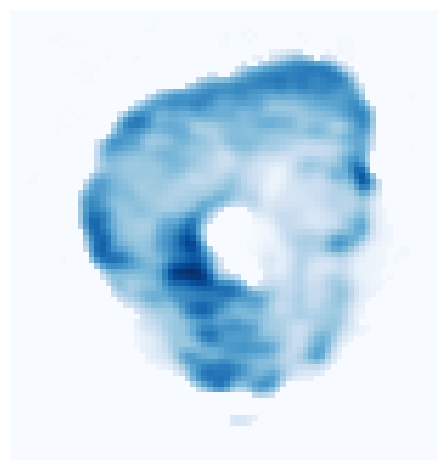

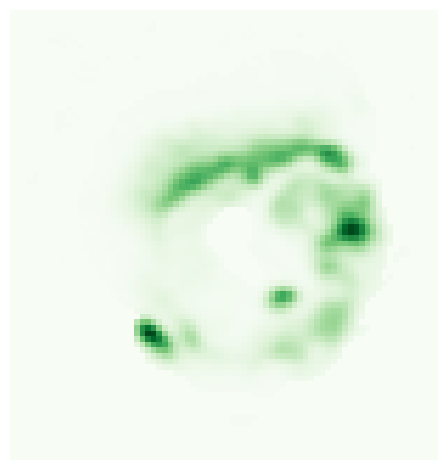

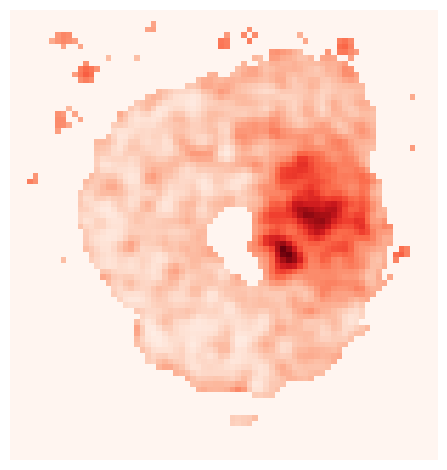

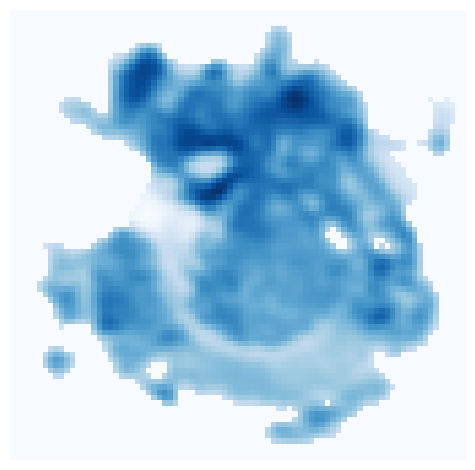

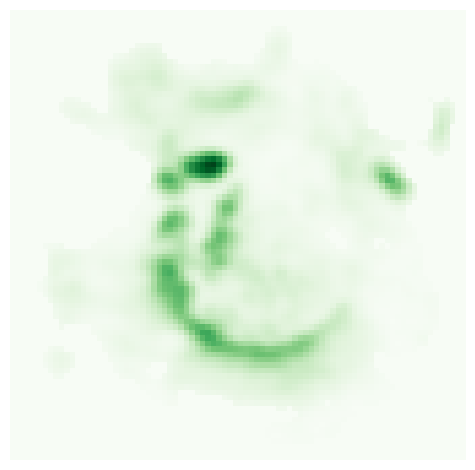

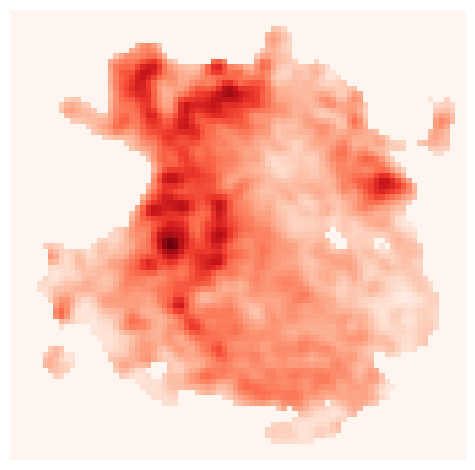

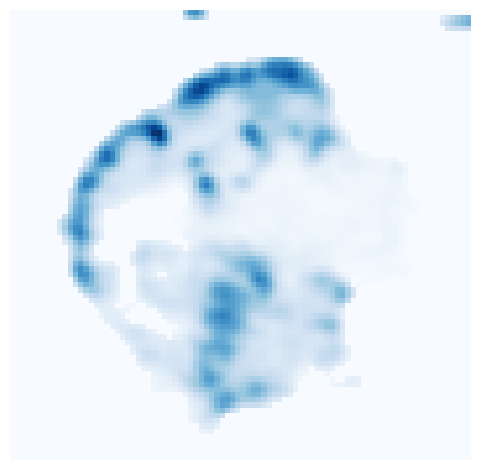

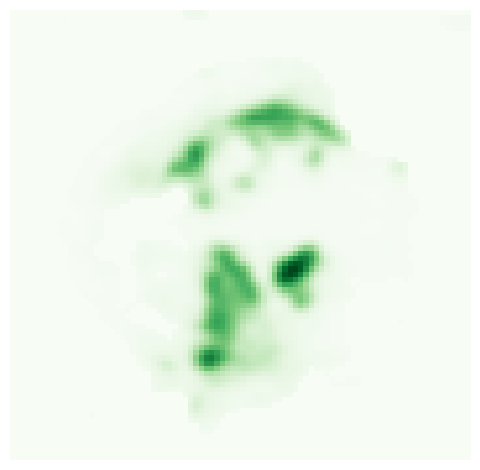

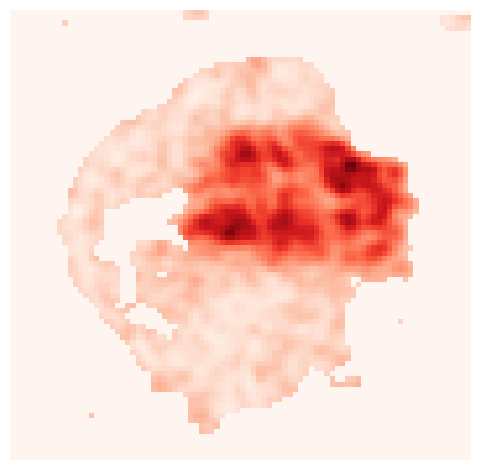

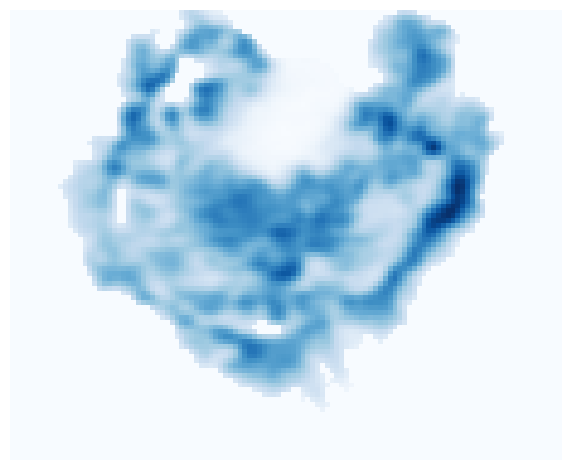

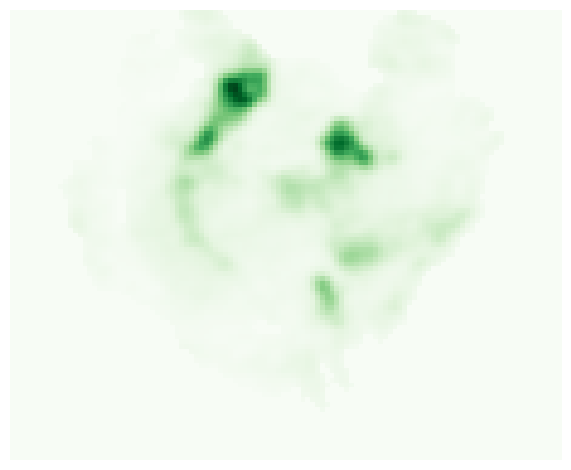

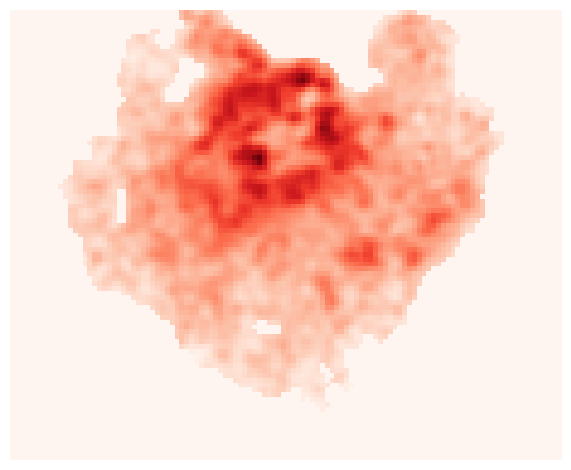

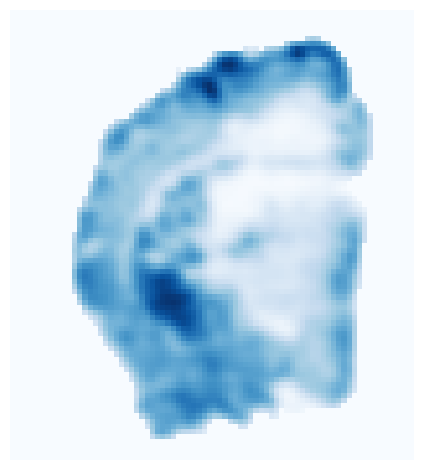

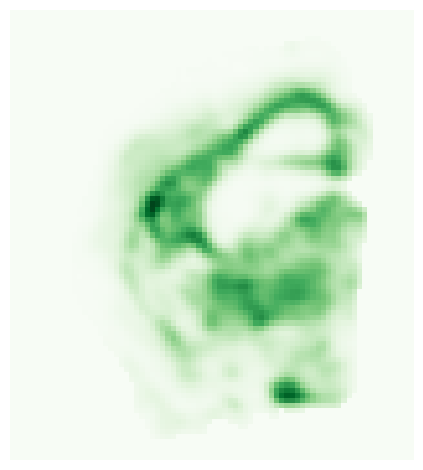

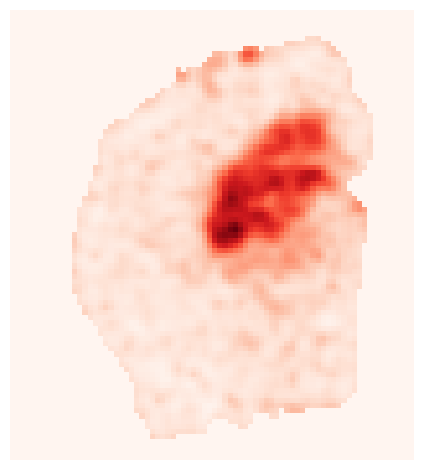

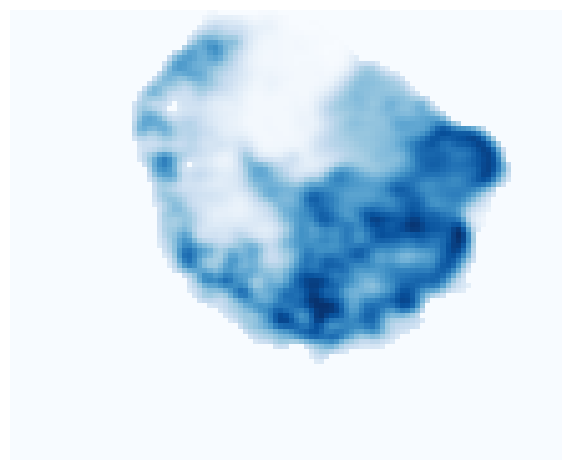

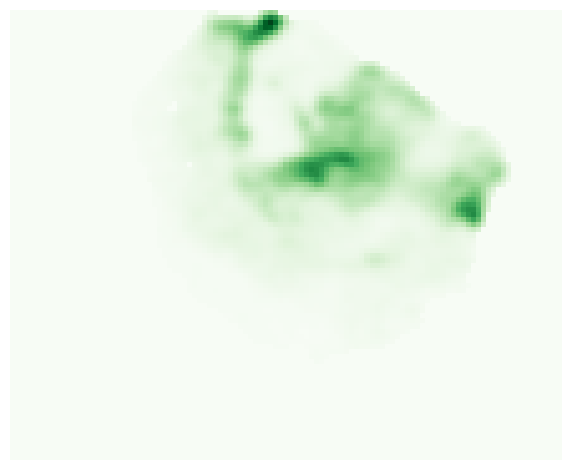

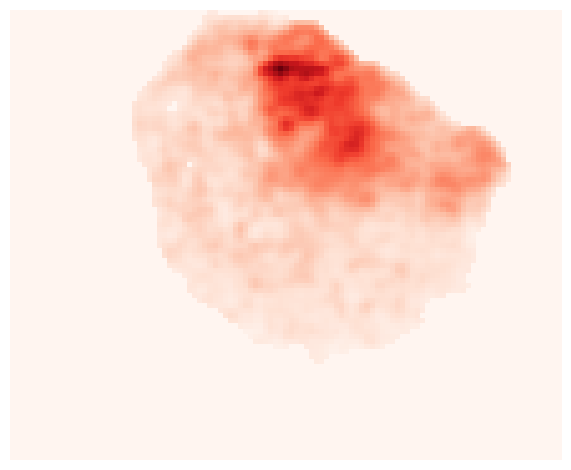

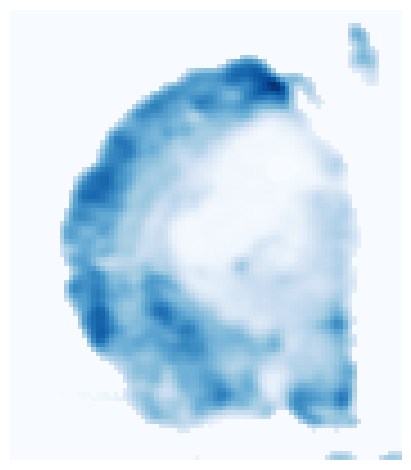

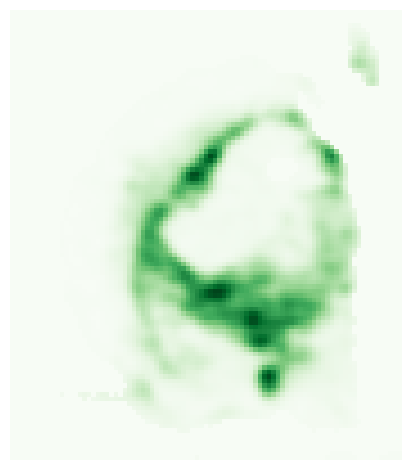

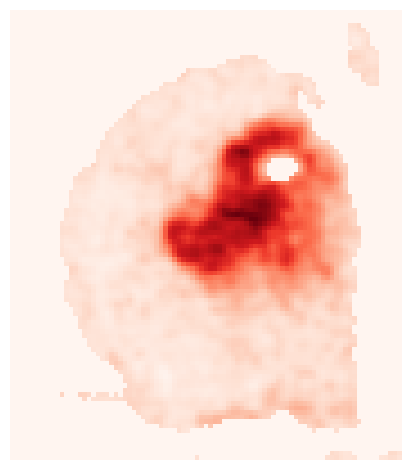

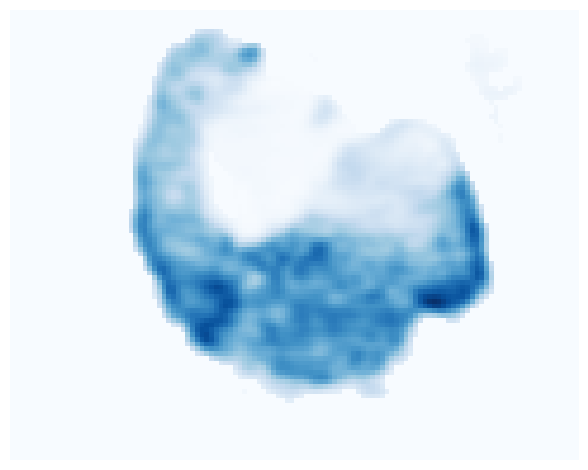

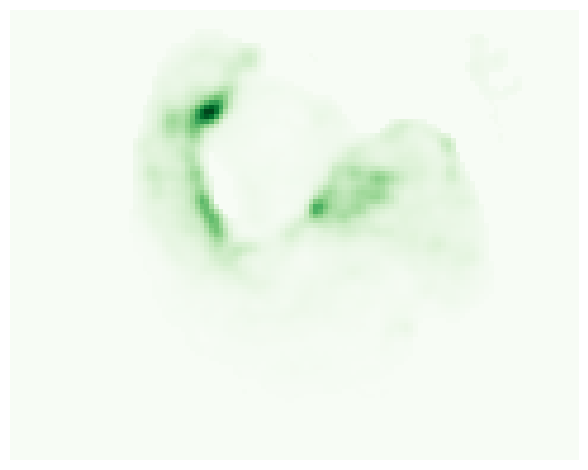

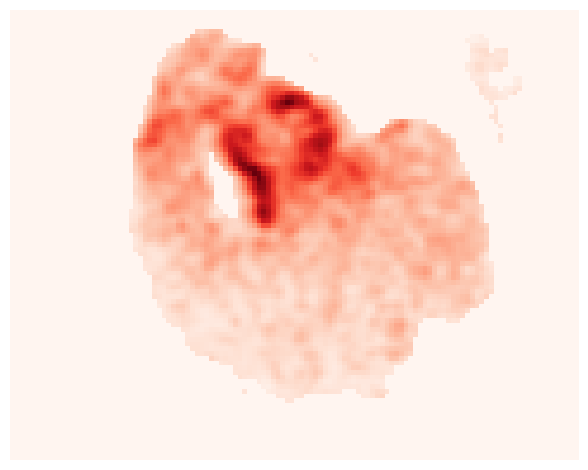

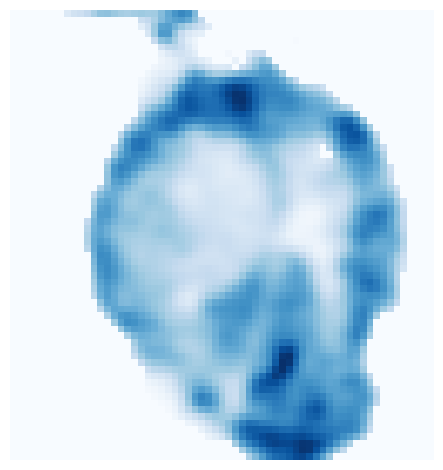

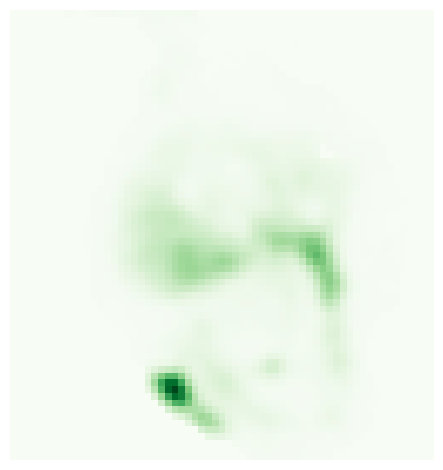

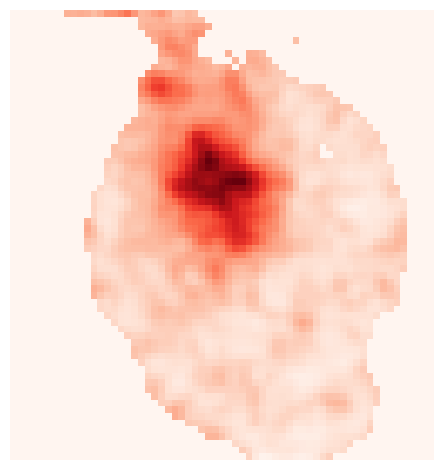

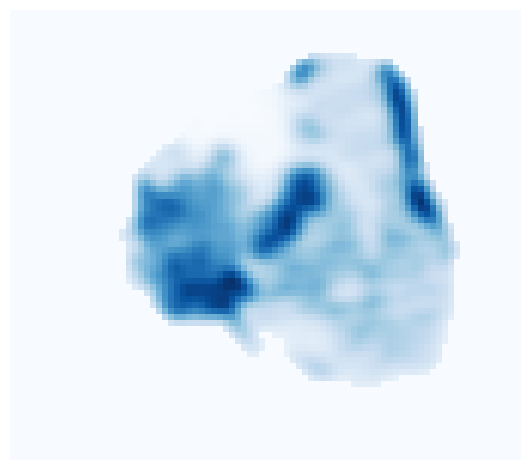

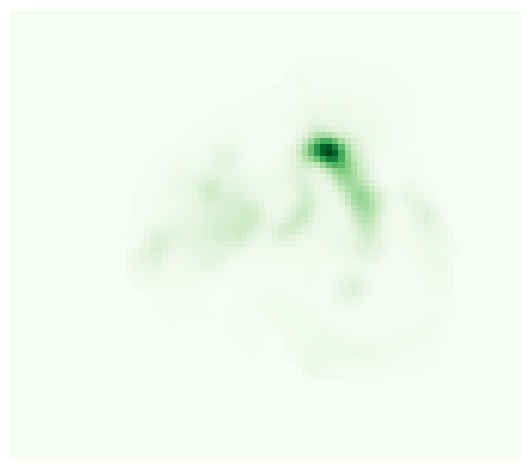

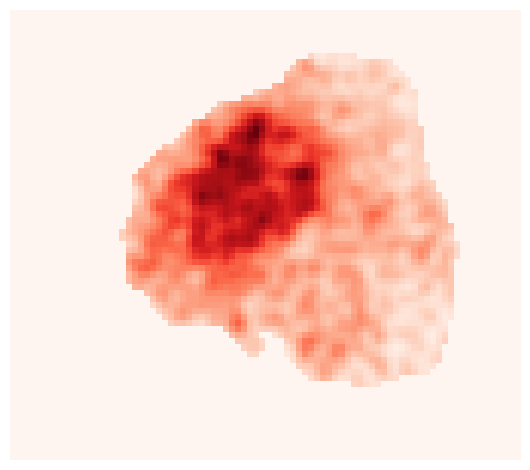

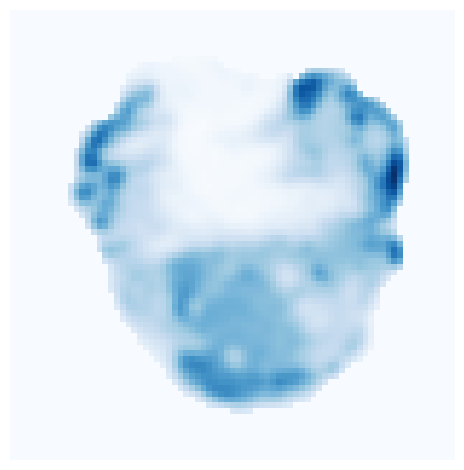

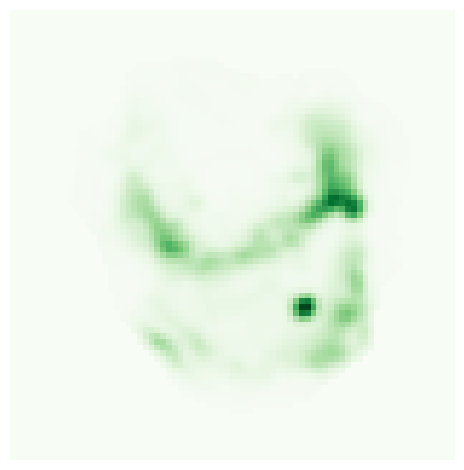

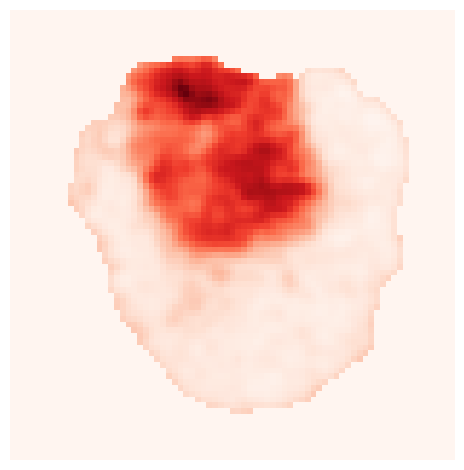

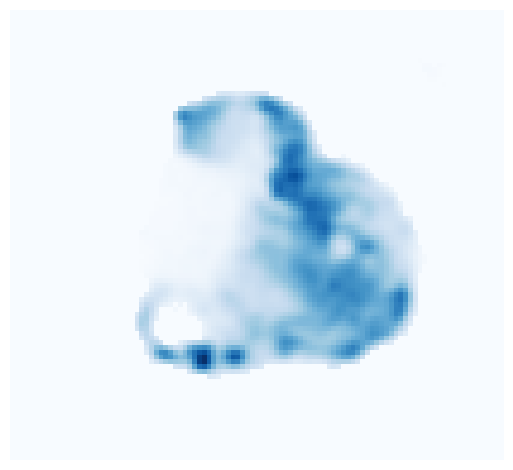

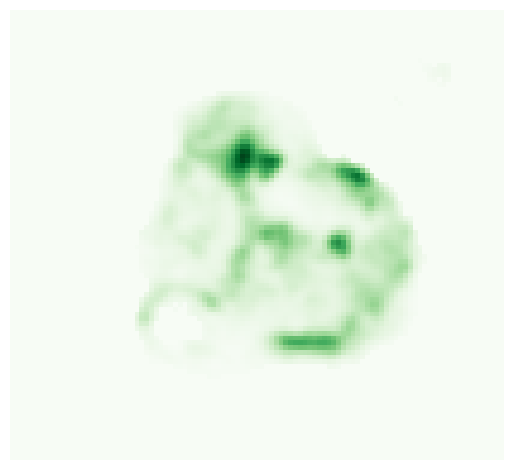

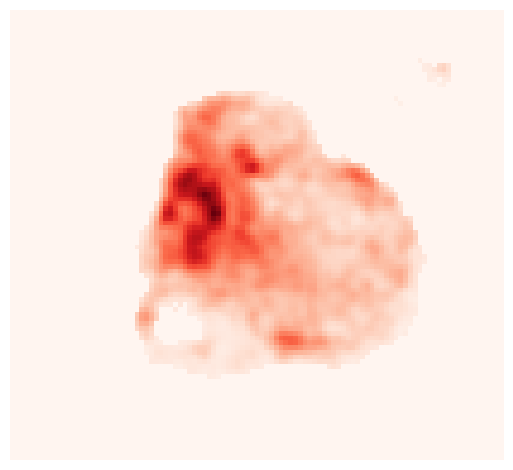

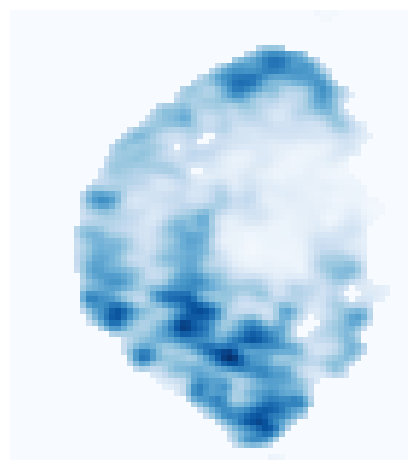

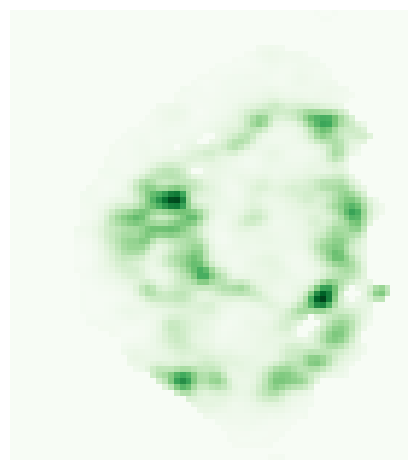

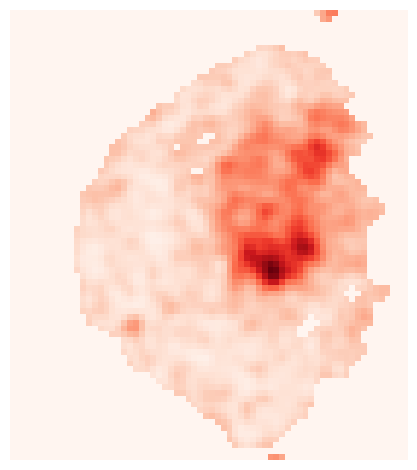

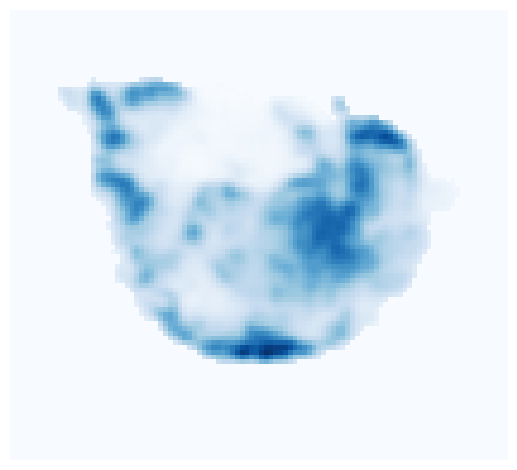

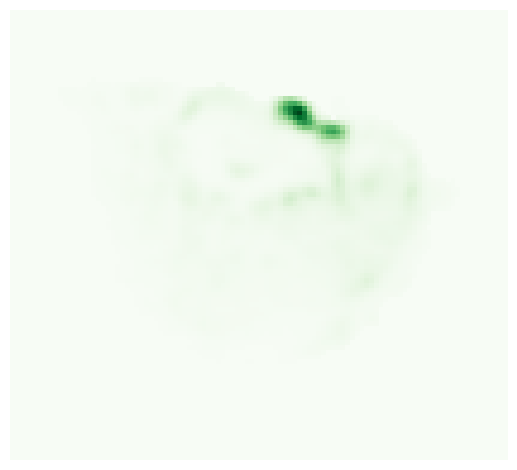

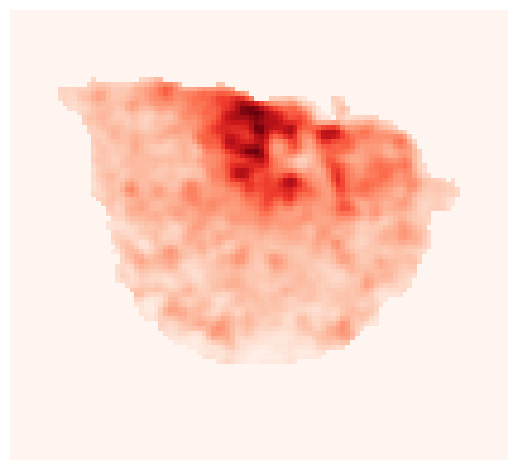

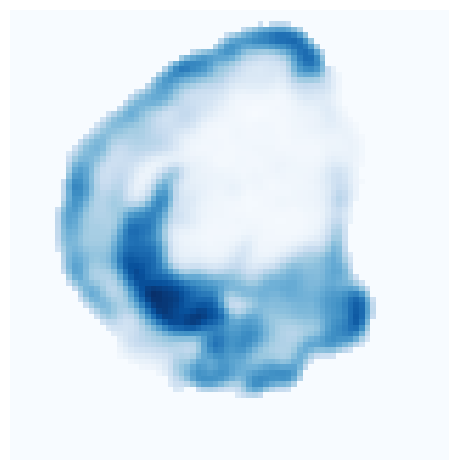

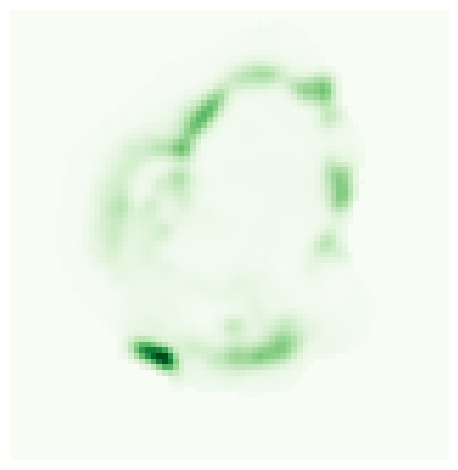

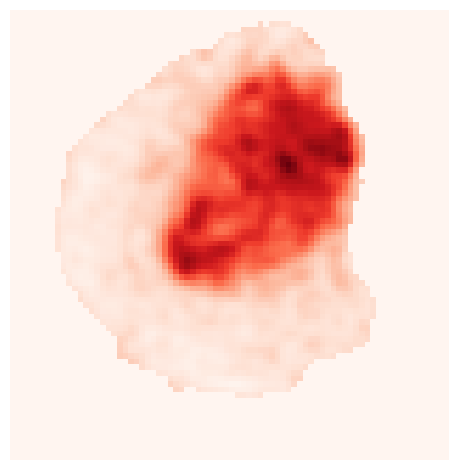

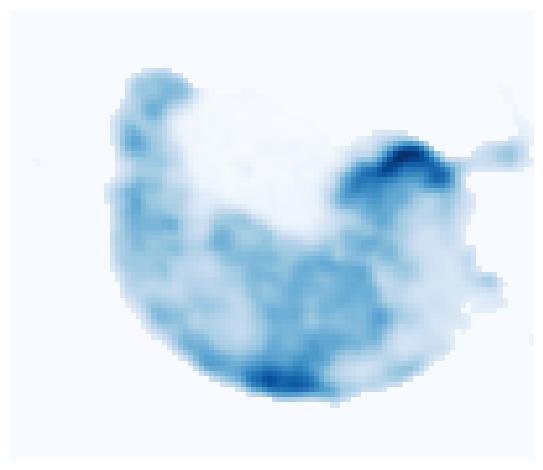

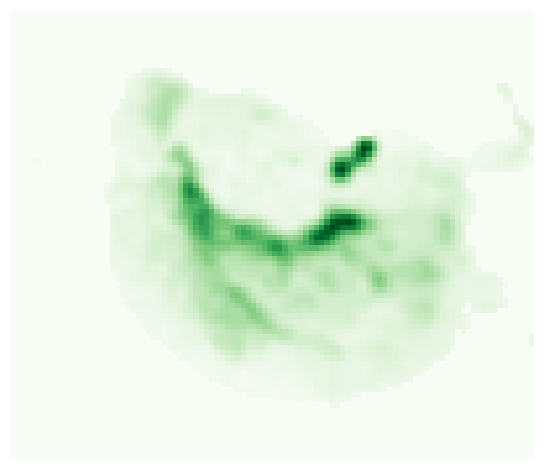

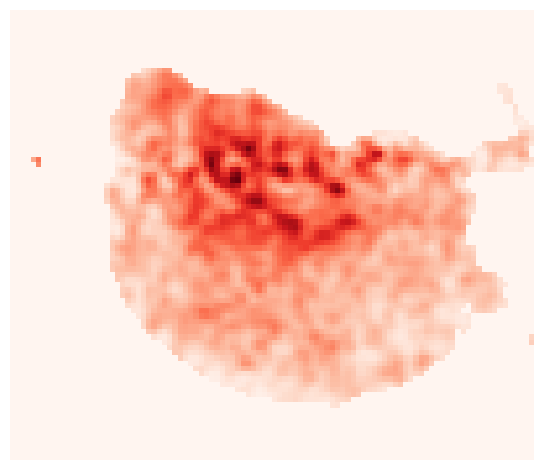

In [5]:
# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

mzs_filter = gray_matter_mzs_filter | tumour_mzs_filter | white_matter_mzs_filter

for img in img_list:
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    plot_img = img[:, :, loop_filter].mean(axis=-1)
    plt.imshow(plot_img, cmap=color_map)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

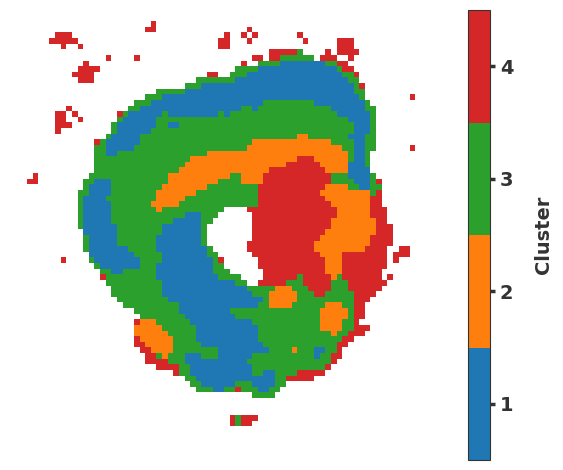

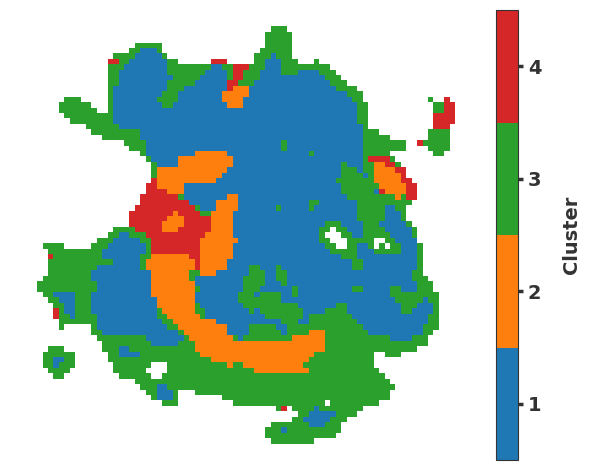

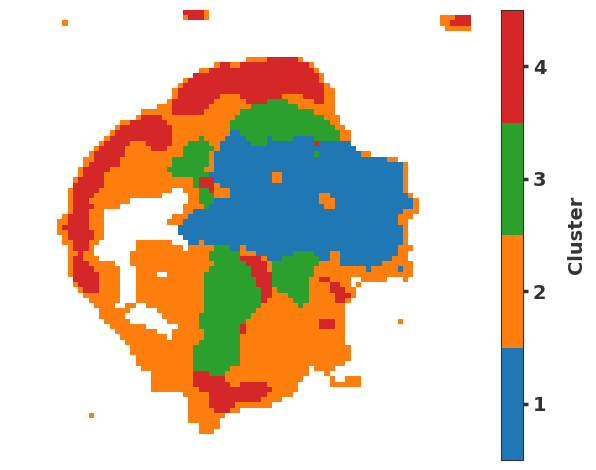

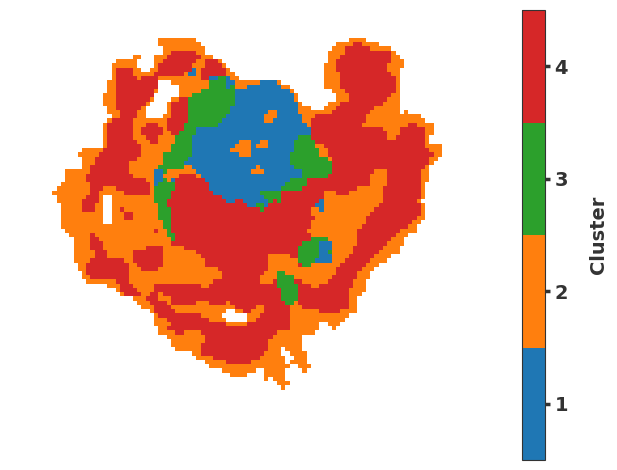

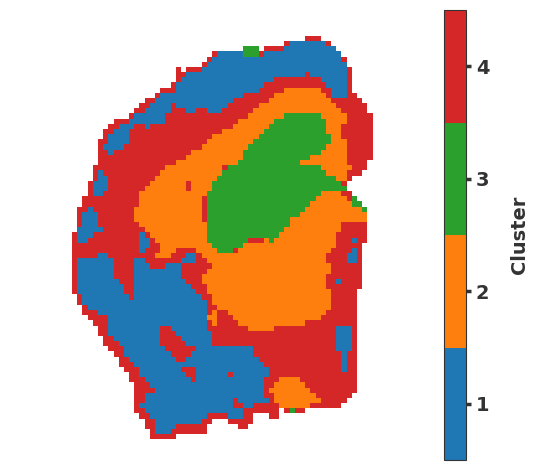

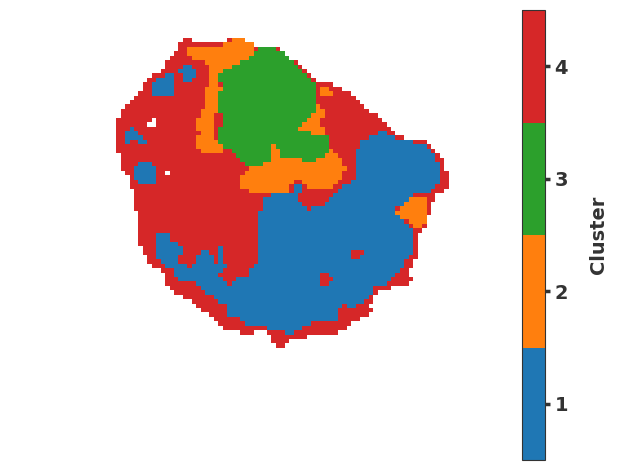

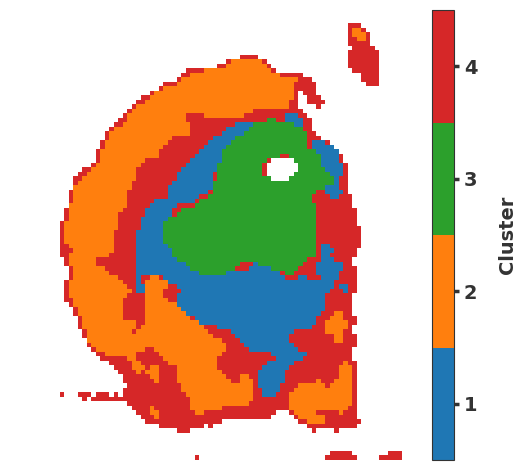

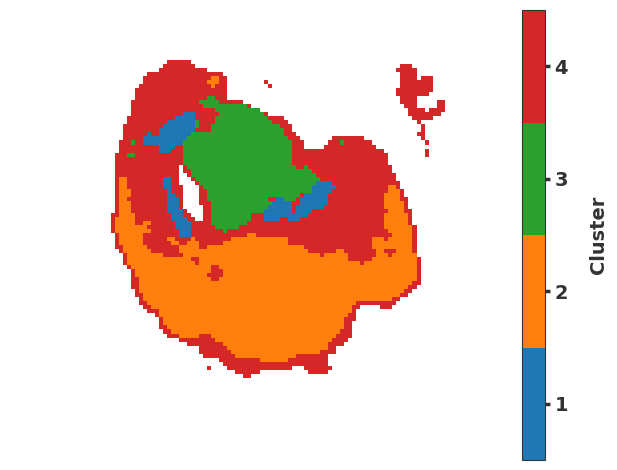

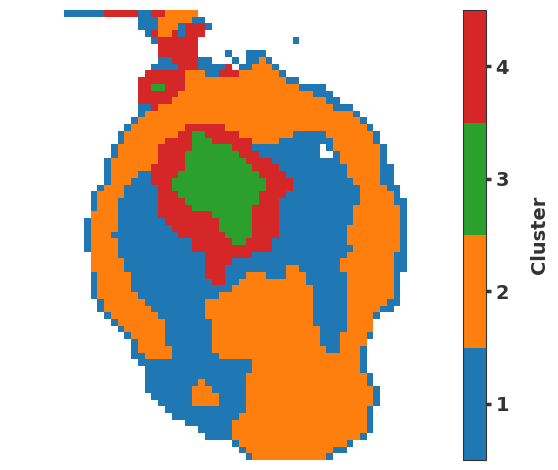

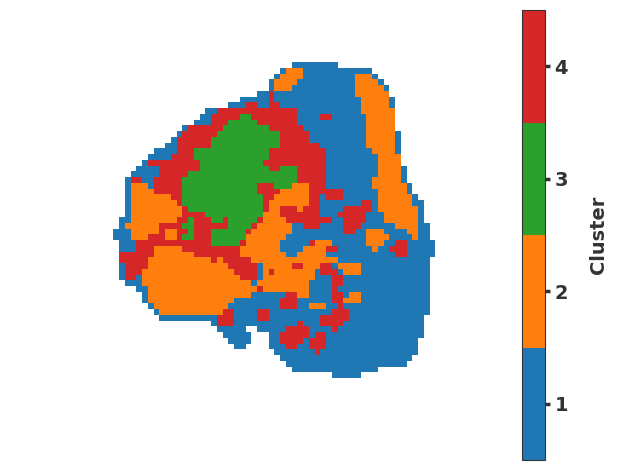

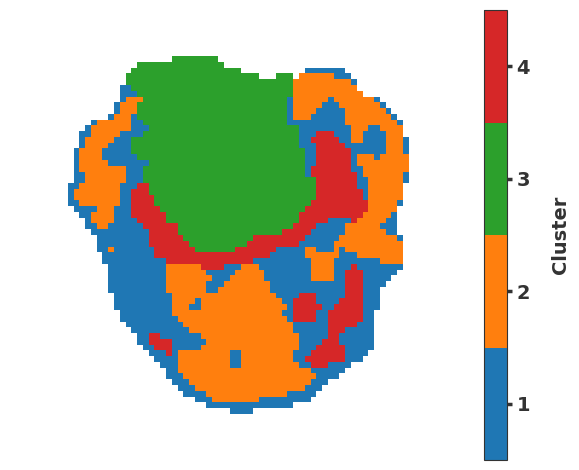

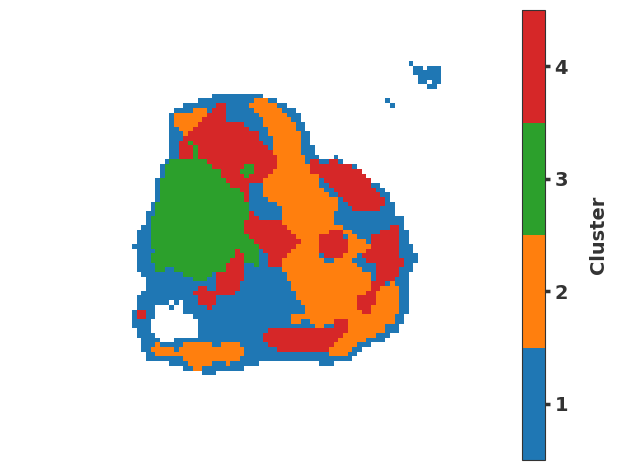

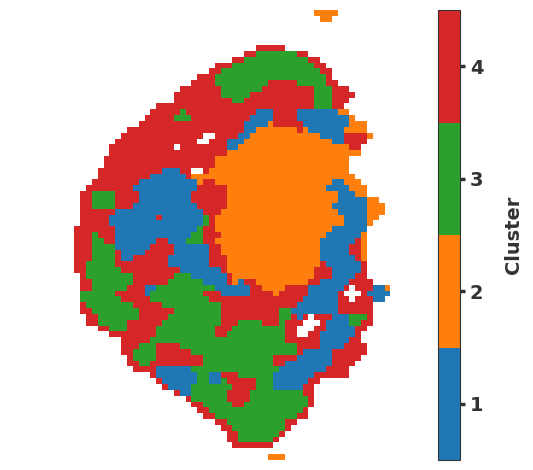

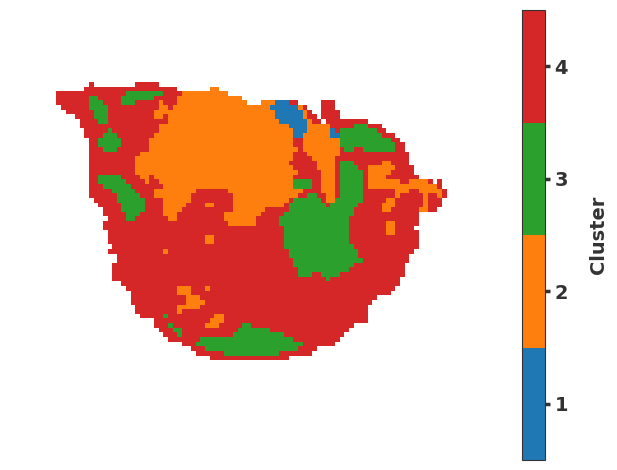

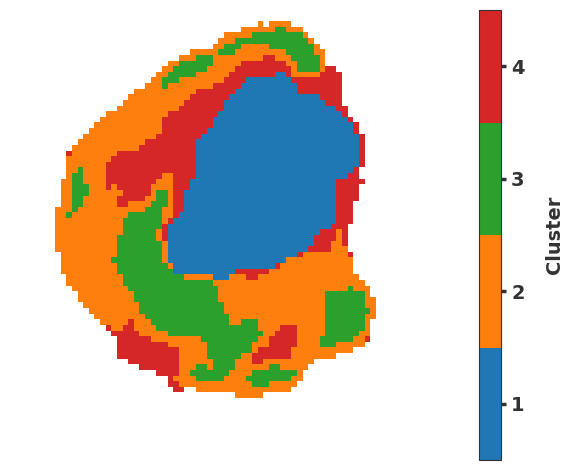

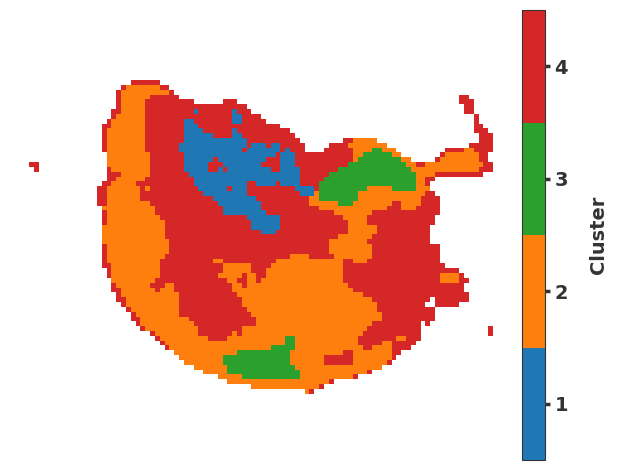

In [6]:
cluster_labels_list = []

for idx in range(0, len(samples_groups) * 2, 2):
  kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(
    img_list[idx][seg_list[idx]][:, mzs_filter]
  )

  for idx_j in [idx, idx+1]:
    new_labels = np.zeros(img_list[idx_j].shape[:-1])
    new_labels[seg_list[idx_j]] = kmeans.predict(
        img_list[idx_j][seg_list[idx_j]][:, mzs_filter]
    ) + 1
    cluster_labels_list.append(new_labels)
    plot_clusters(new_labels, n_clusters)

In [13]:
from sklearn.manifold import TSNE


def plot_tsne(data, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create and fit the t-SNE model
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(data)

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend()
  plt.show()

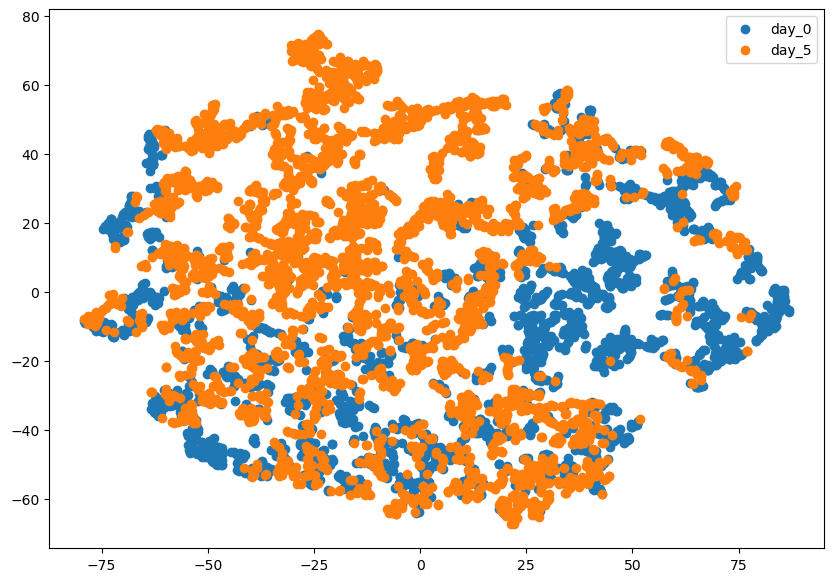

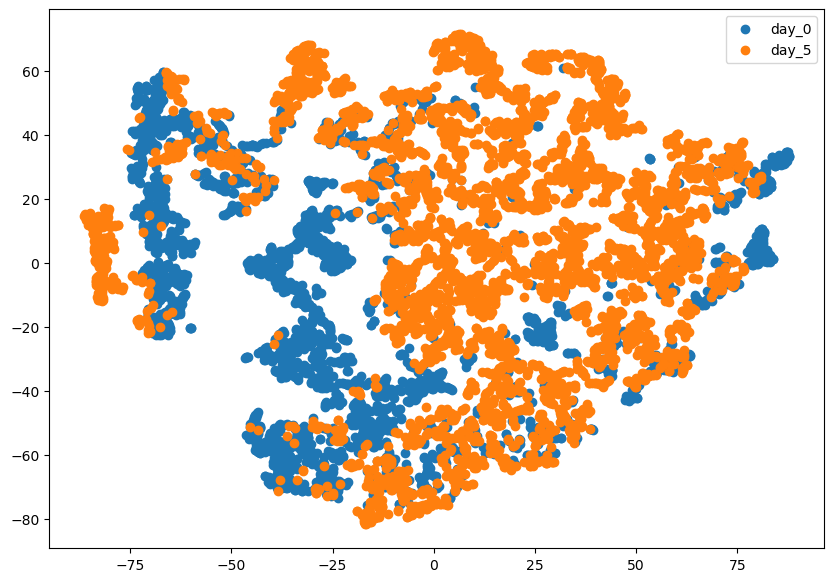

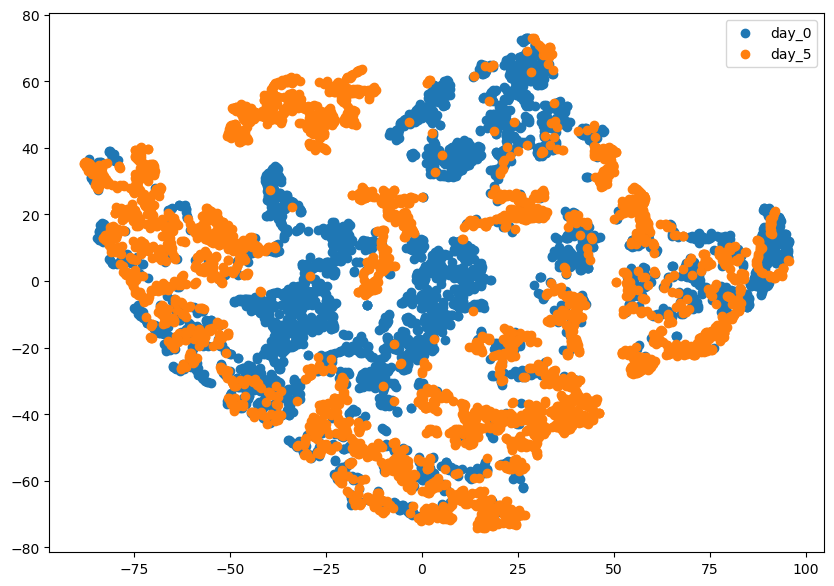

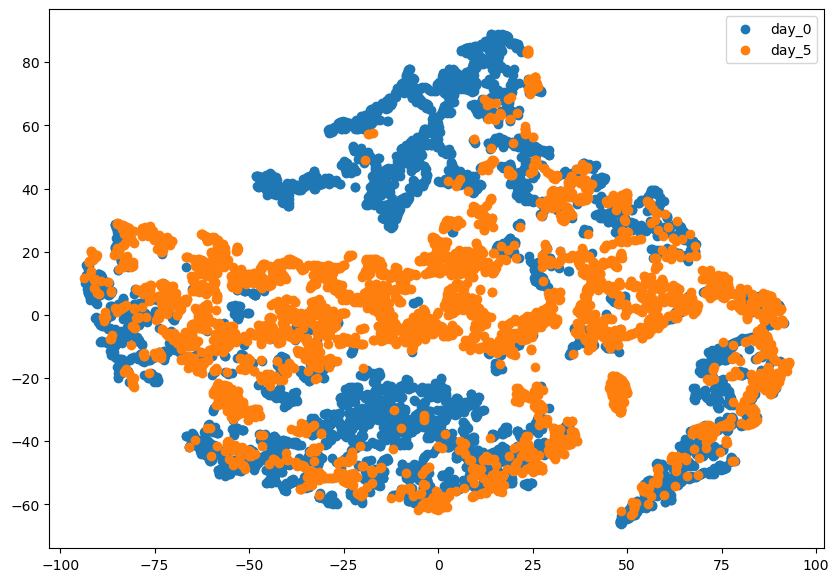

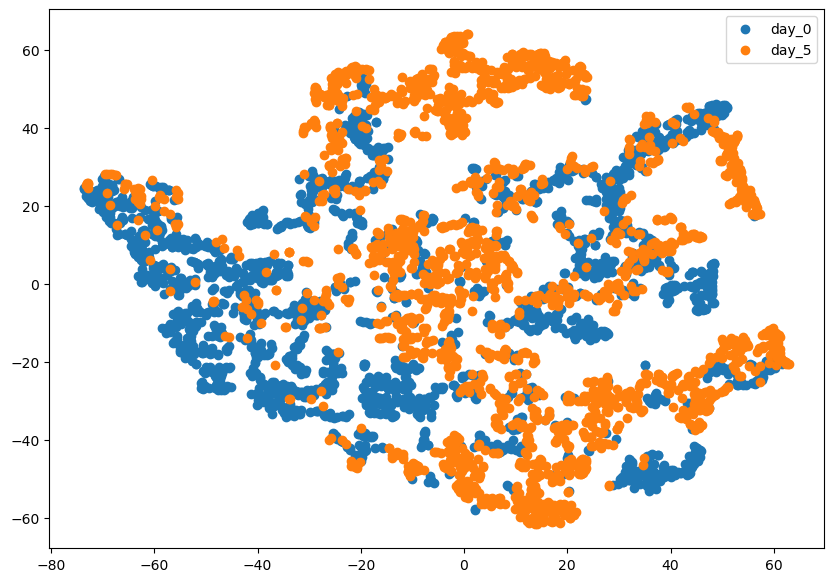

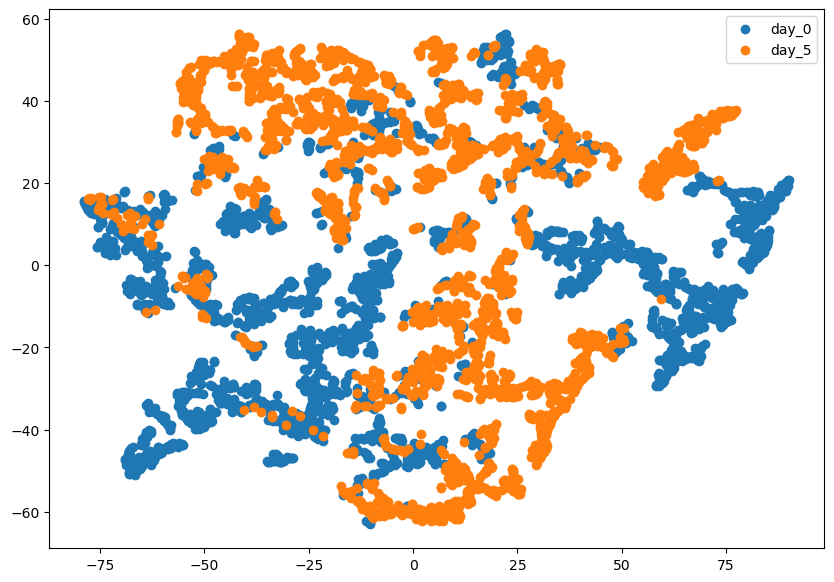

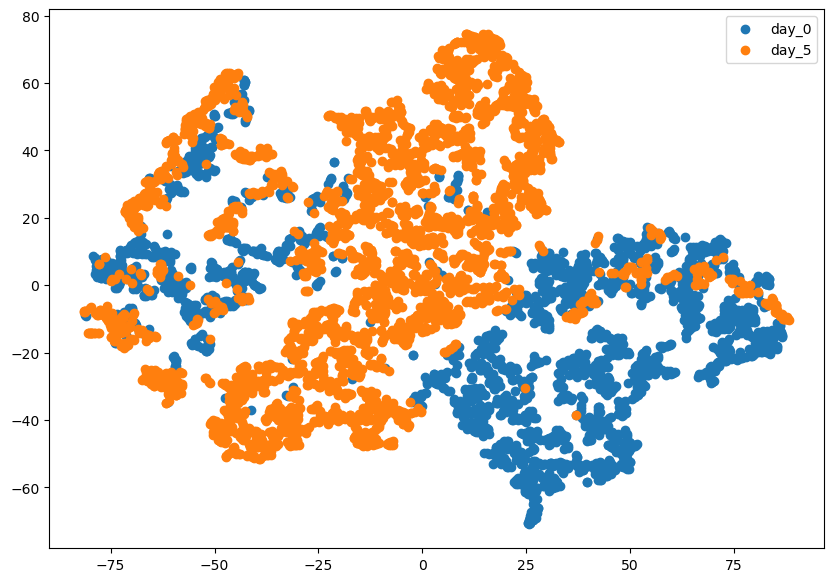

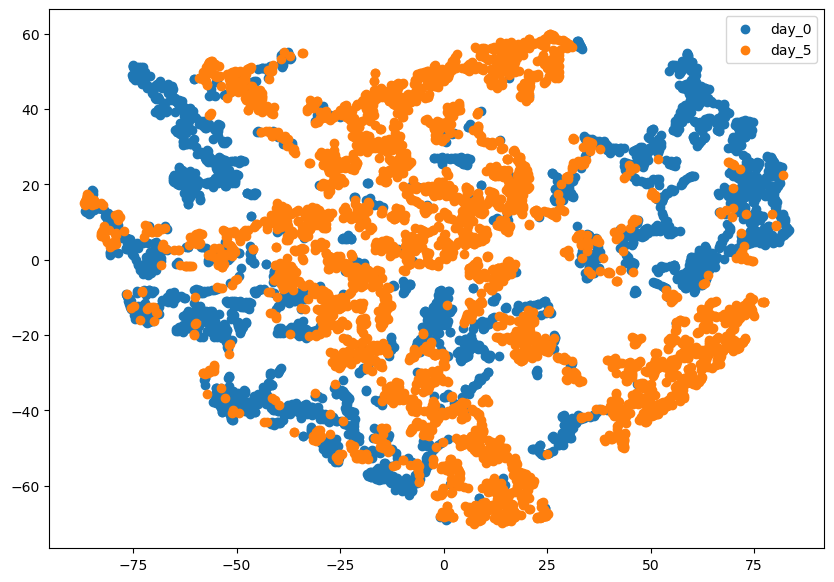

In [ ]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[idx][seg_list[idx]][:, mzs_filter], img_list[idx+1][seg_list[idx+1]][:, mzs_filter]]
      ),
      np.concatenate(
          [
              ["day_0"] * img_list[idx][seg_list[idx]].shape[0],
              ["day_5"] * img_list[idx + 1][seg_list[idx + 1]].shape[0]
          ]
      )
  )

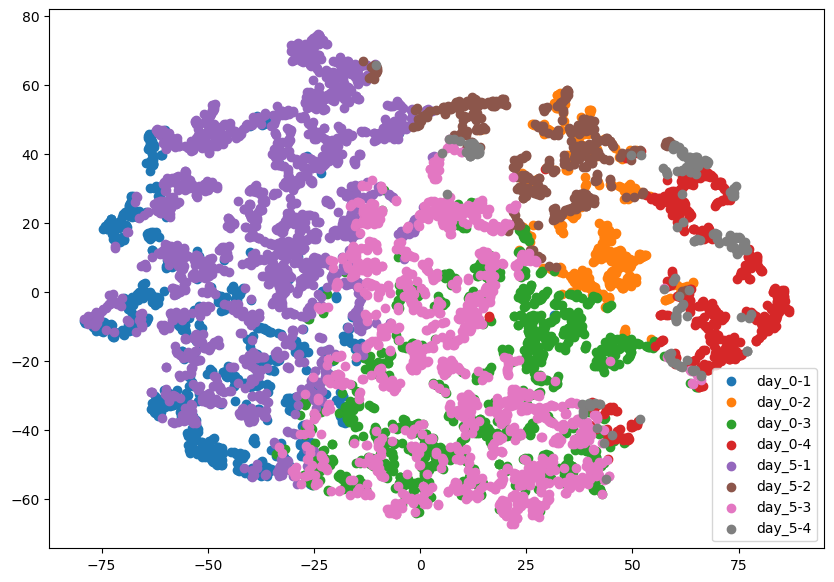

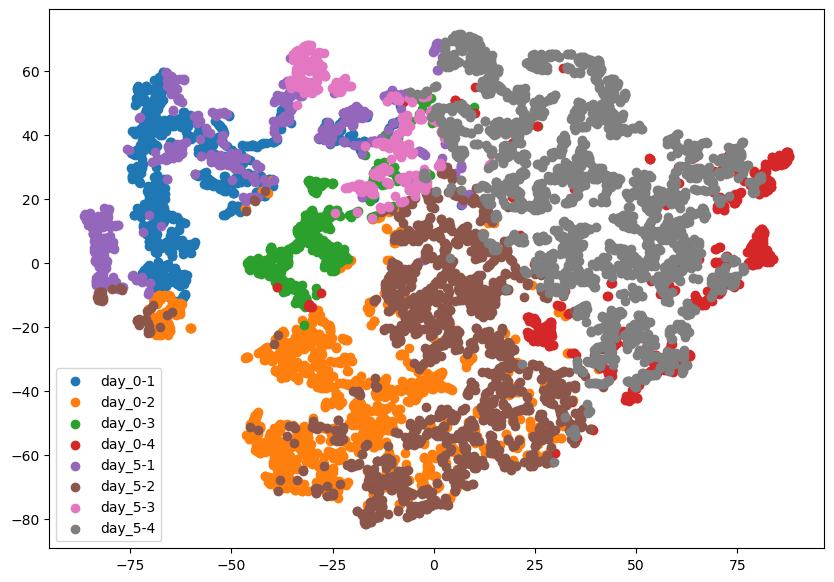

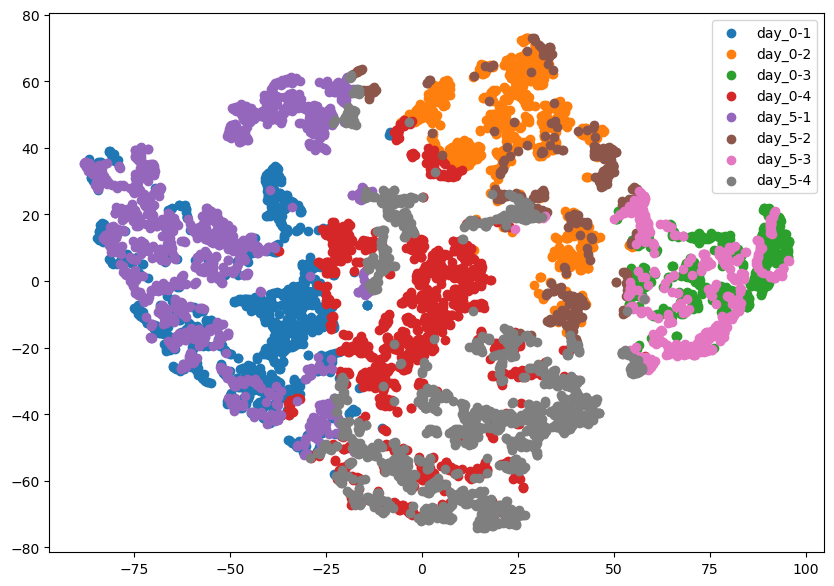

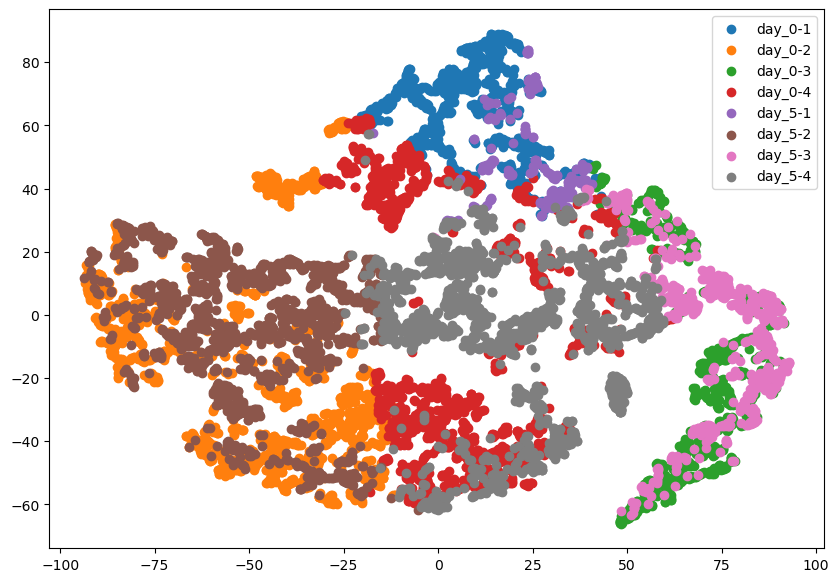

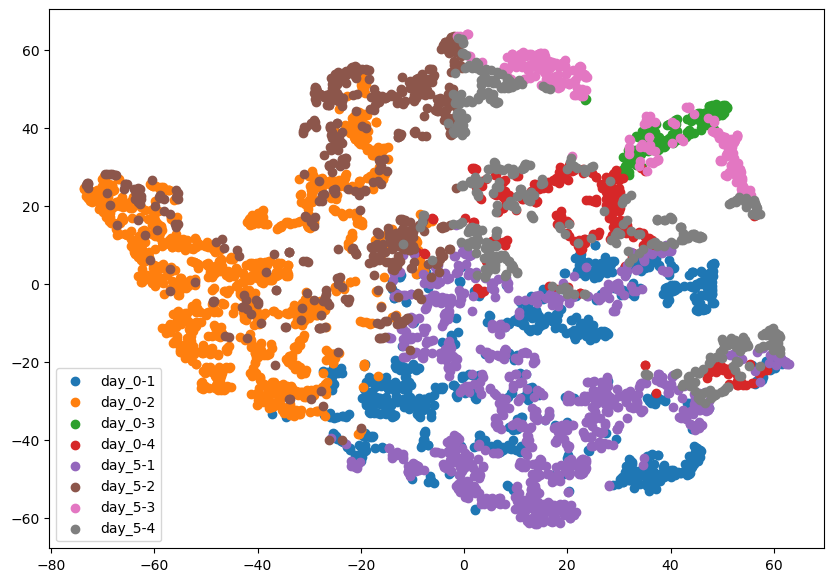

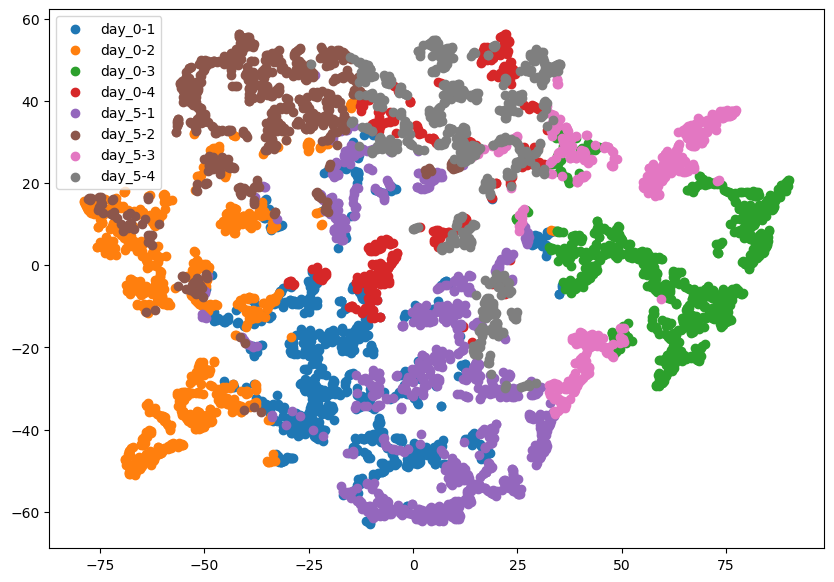

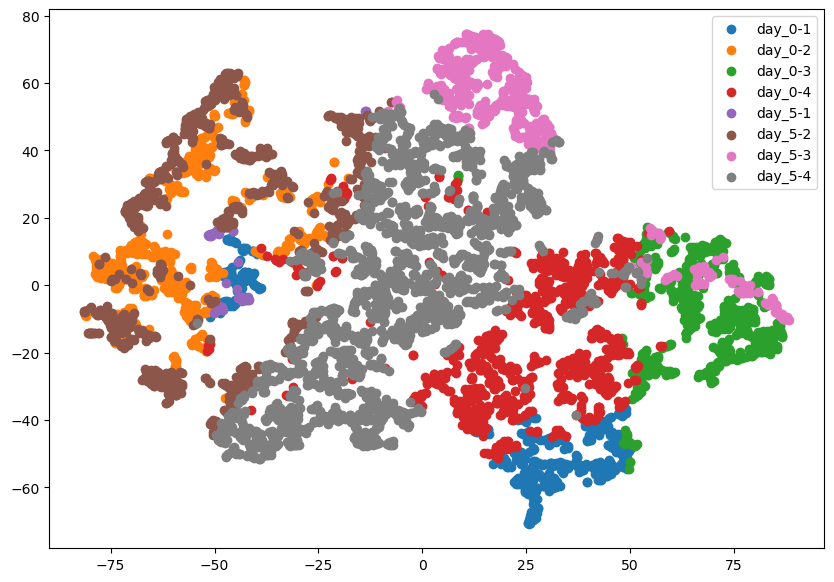

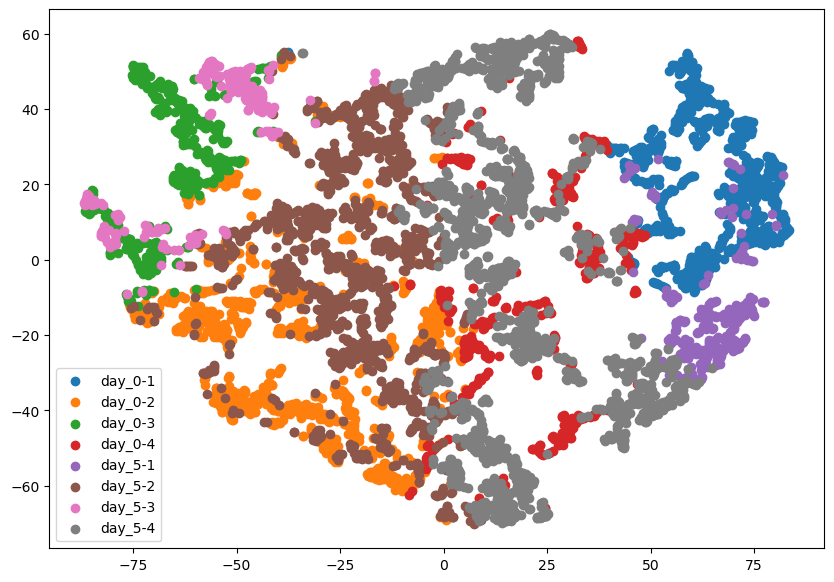

In [9]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[idx][seg_list[idx]][:, mzs_filter], img_list[idx+1][seg_list[idx+1]][:, mzs_filter]]
      ),
      np.concatenate(
          [
              list(
                  map(
                      lambda x: f"day_0-{int(x)}",
                      cluster_labels_list[idx][seg_list[idx]]
                  )
              ),
              list(
                  map(
                      lambda x: f"day_5-{int(x)}",
                      cluster_labels_list[idx + 1][seg_list[idx + 1]]
                  )
              )
          ]
      )
  )

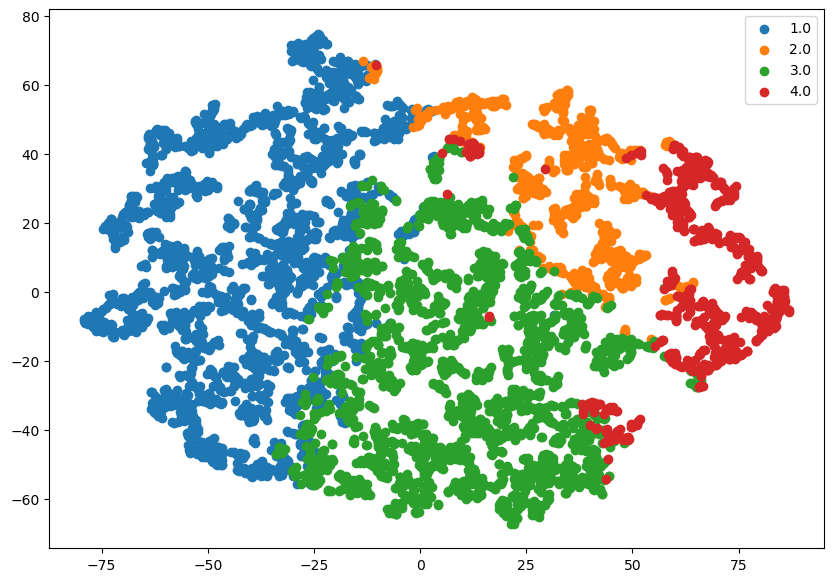

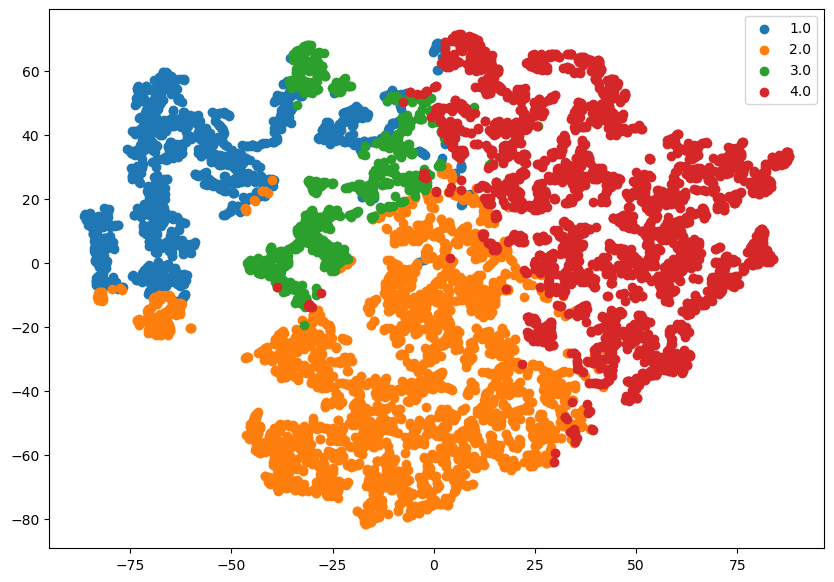

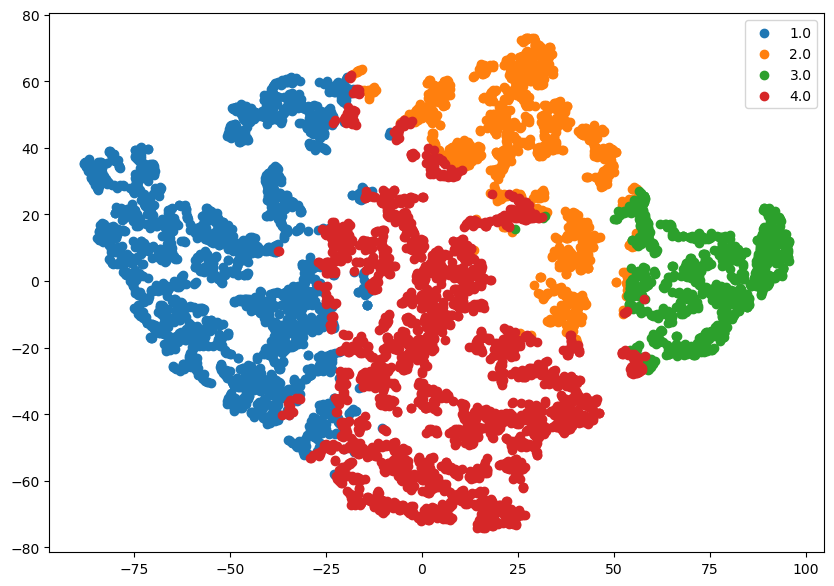

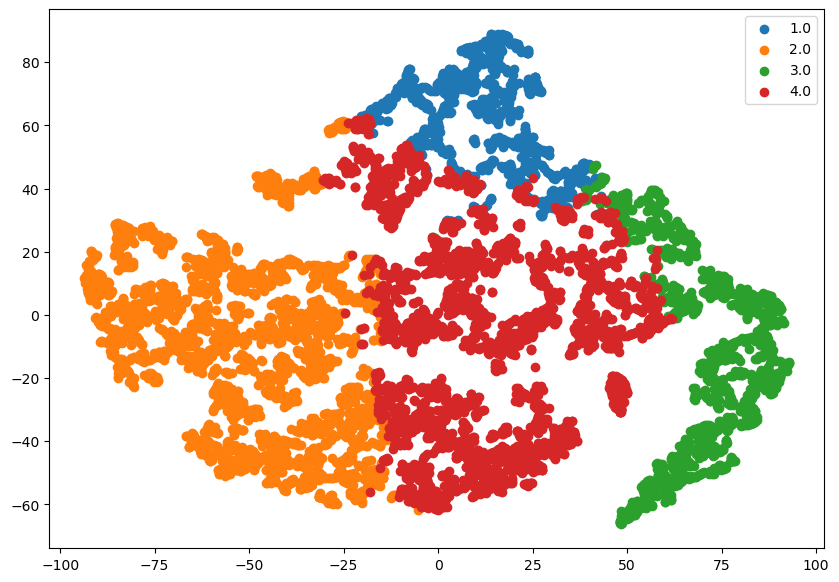

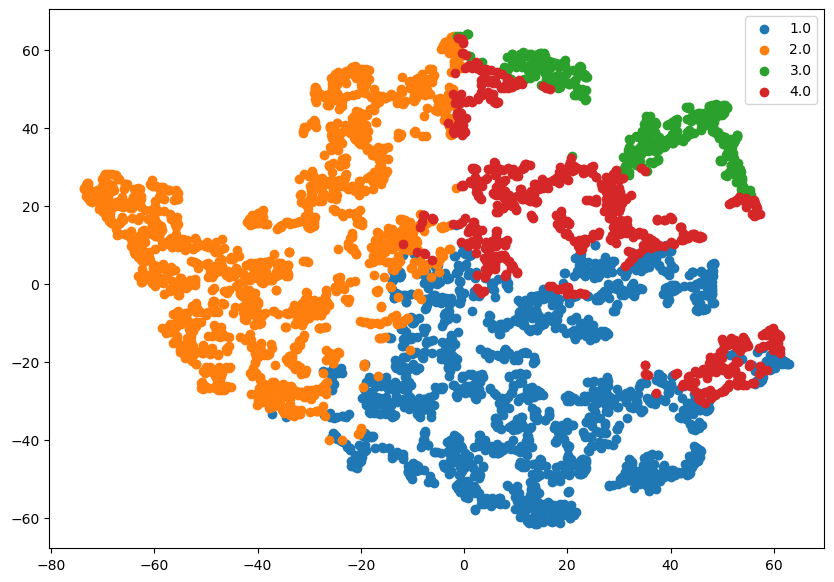

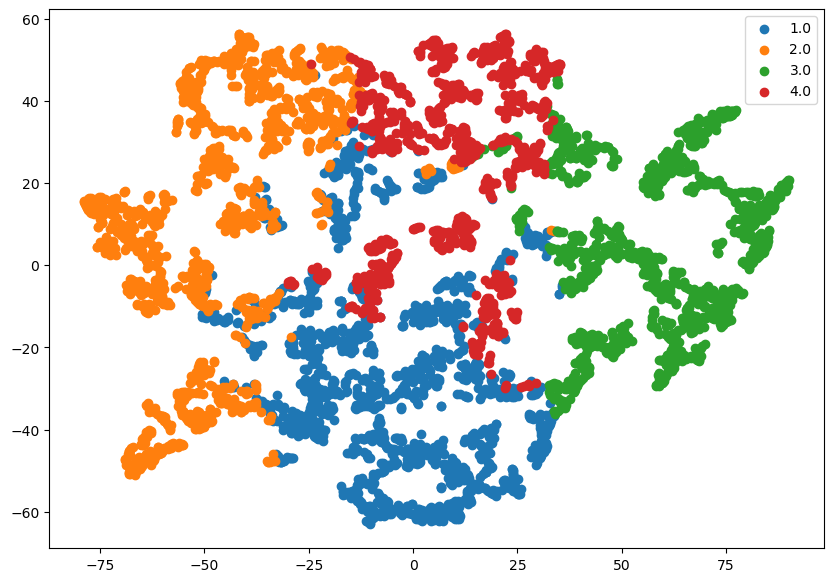

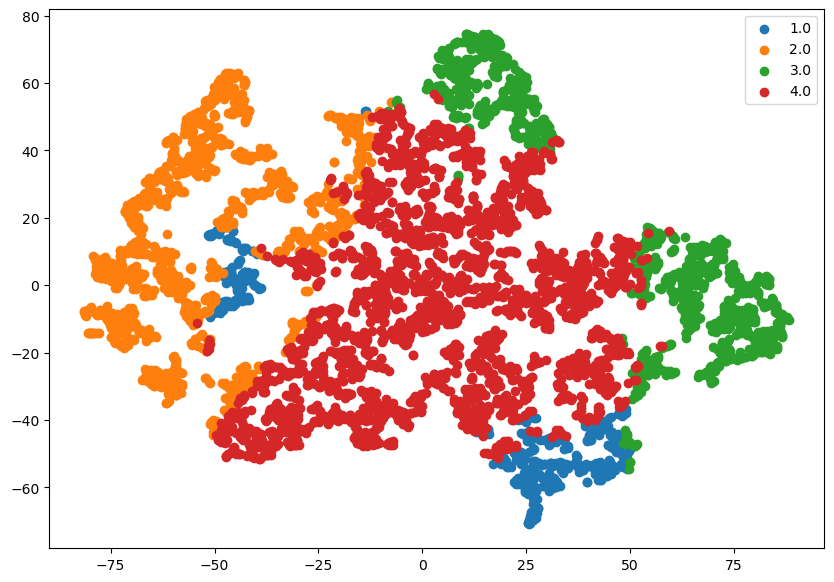

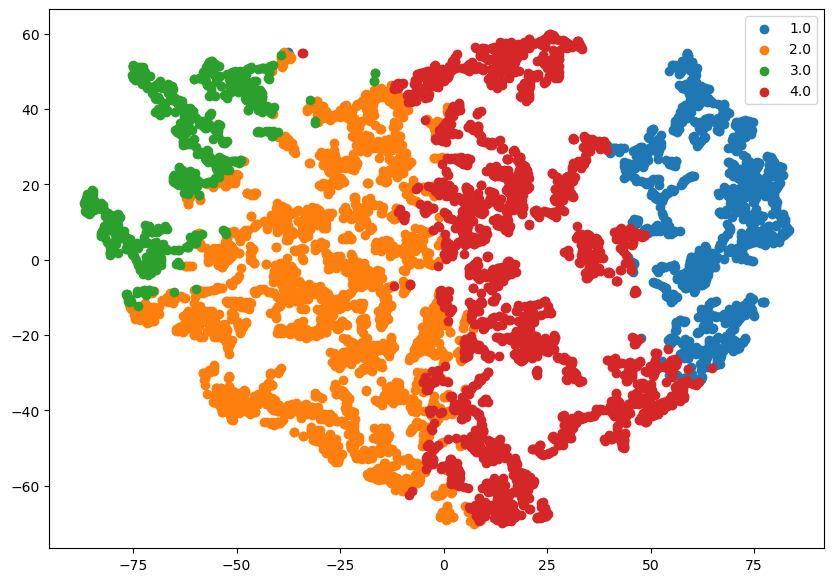

In [10]:
for idx in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[idx][seg_list[idx]][:, mzs_filter], img_list[idx+1][seg_list[idx+1]][:, mzs_filter]]
      ),
      np.concatenate(
          [
              cluster_labels_list[idx][seg_list[idx]],
              cluster_labels_list[idx + 1][seg_list[idx + 1]]
          ]
      )
  )

In [7]:
# Computes and prints the mean cluster vectors filtered by predefined lipids
# (gray matter, white matter, and tumour) for each unique cluster. Determine if
# a cluster belongs to gray matter, white matter, or tumour by highest sum of
# the mean cluster vector elements.

for idx, (img, cluster_labels) in enumerate(zip(img_list, cluster_labels_list)):
  if idx % 2 == 0:
    print(idx)
    for label in np.unique(cluster_labels):
      if label > 0:
        mean_cluster_vector = img[cluster_labels == label].mean(axis=0)
        for name, loop_filter in zip(
            ["gray_matter", "white_matter", "tumour"],
            [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
        ):
          print(
              label, name, mean_cluster_vector[loop_filter],
              mean_cluster_vector[loop_filter].sum(), sep=", "
          )

0
1.0, gray_matter, [3.09757076 3.10714721 2.47009704 3.03545911], 11.71027411677173
1.0, white_matter, [0.15951728 0.1978773  0.19612887 0.15806259], 0.711586057031105
1.0, tumour, [0.74569708 0.86033406 0.73359254 0.99030901], 3.329932684557402
2.0, gray_matter, [1.55852027 1.54475939 1.22461563 1.44958891], 5.777484195757429
2.0, white_matter, [1.76192291 2.19595461 2.22828839 1.79031957], 7.976485486041644
2.0, tumour, [1.47315327 1.51110112 1.23265433 1.39461912], 5.611527829592385
3.0, gray_matter, [1.89217889 1.91313866 1.53037169 1.87034721], 7.2060364450825185
3.0, white_matter, [0.4401073  0.55124307 0.56222713 0.45527918], 2.0088566745811107
3.0, tumour, [0.78170399 0.94651105 0.82574986 1.16455467], 3.7185195710124024
4.0, gray_matter, [0.70895779 0.68682188 0.54212143 0.64221107], 2.5801121752249605
4.0, white_matter, [0.42258449 0.52477704 0.53092033 0.42602994], 1.9043118016601948
4.0, tumour, [1.6122641  1.9426299  1.69532353 2.37120848], 7.621426004246795
2
1.0, gray_m

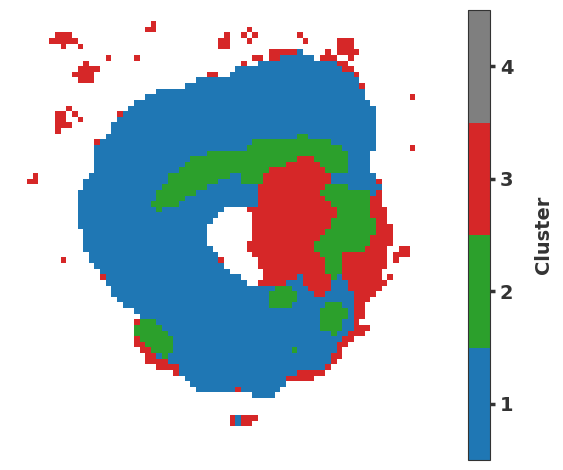

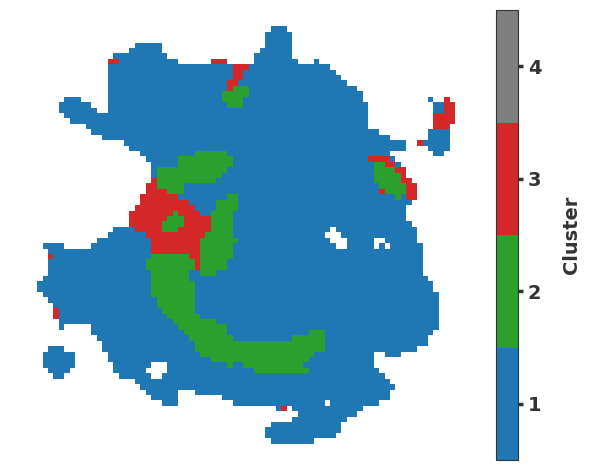

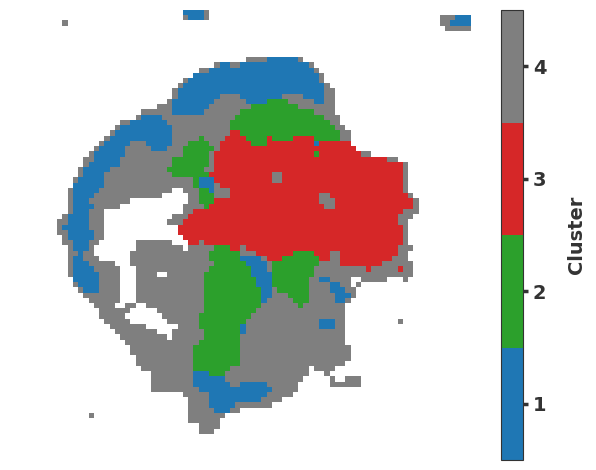

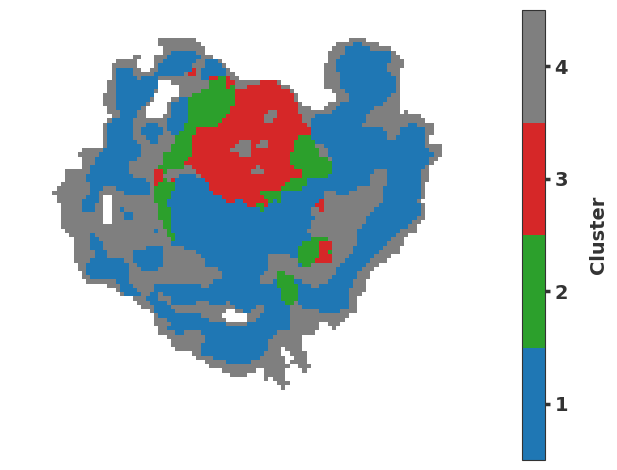

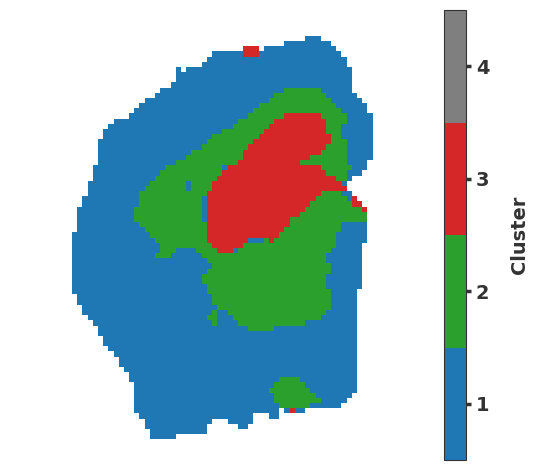

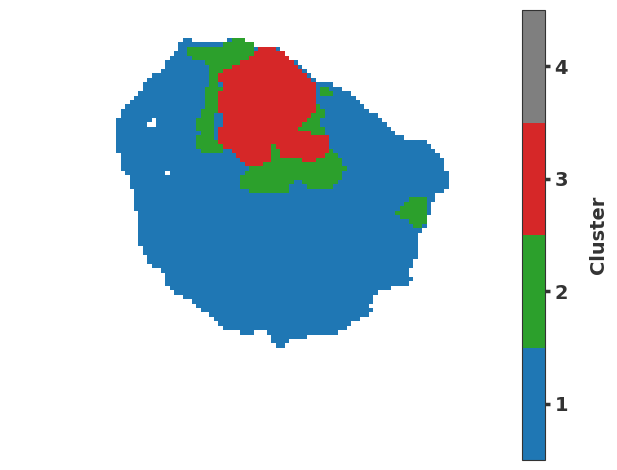

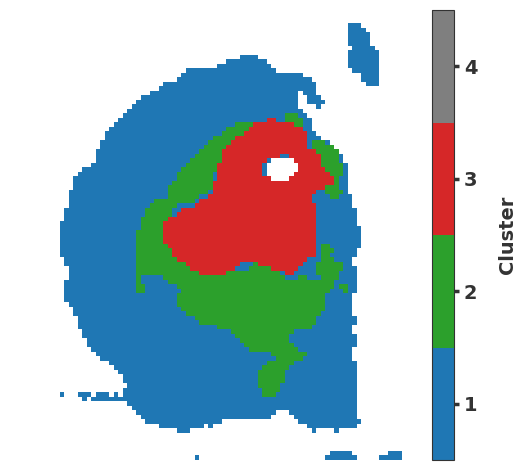

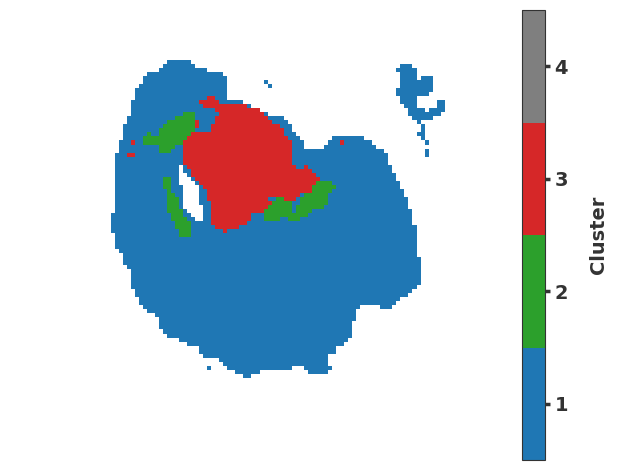

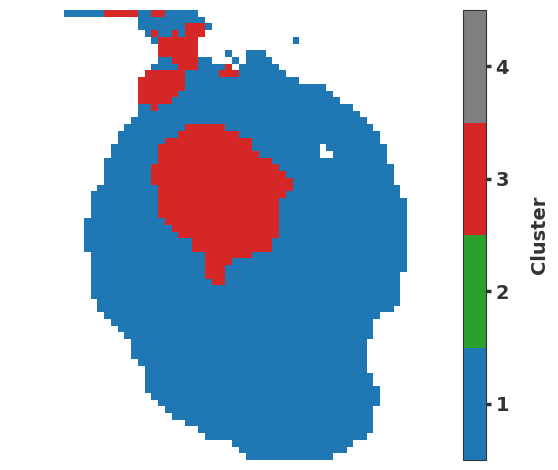

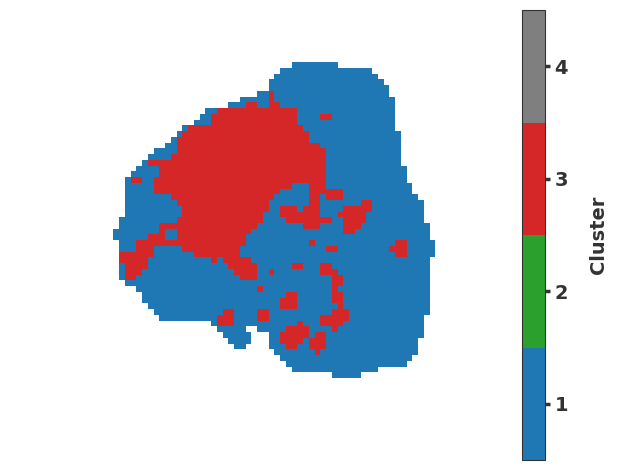

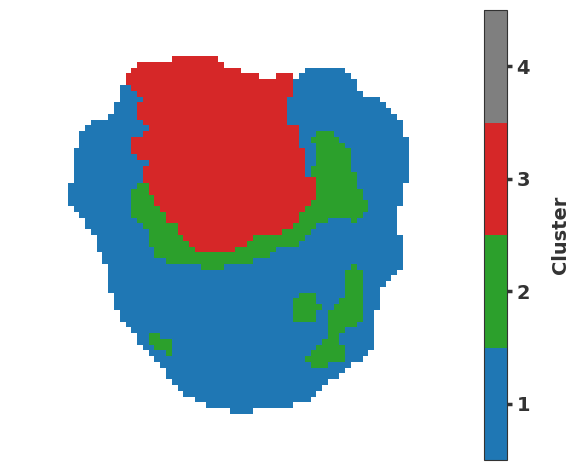

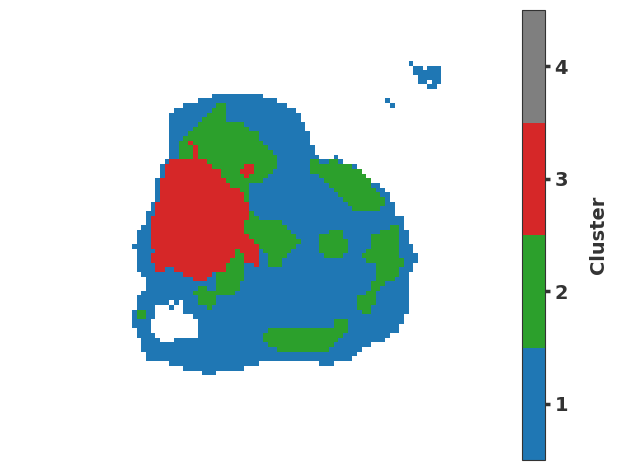

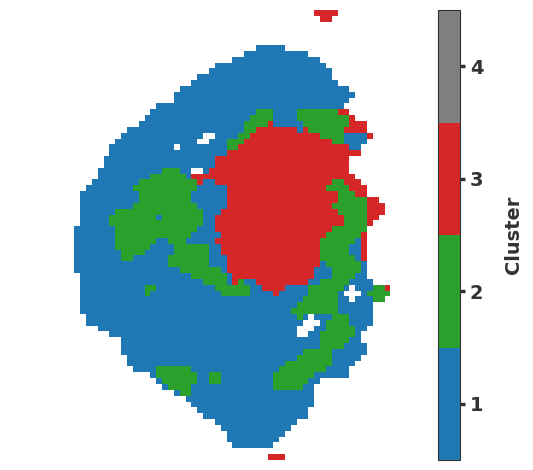

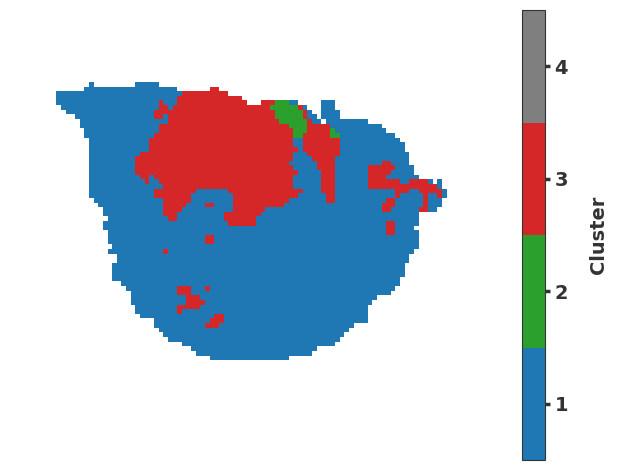

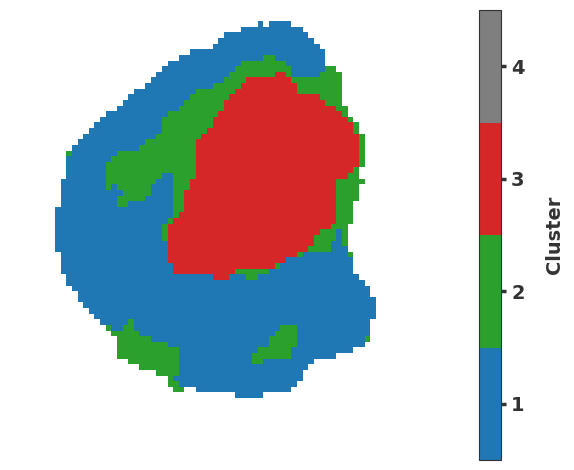

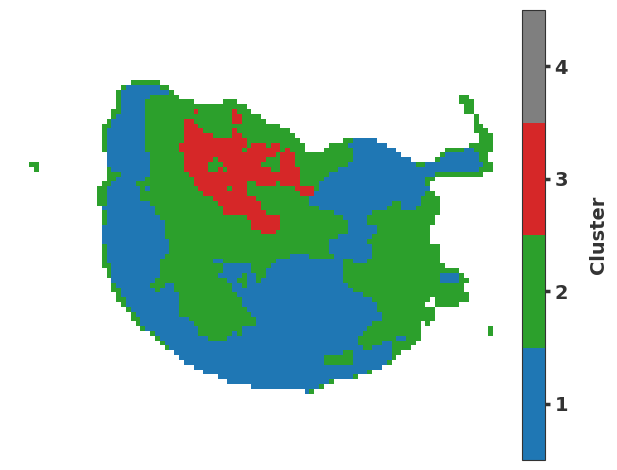

In [8]:
from matplotlib.colors import ListedColormap, to_rgba

cluster_map = {
  0: {
    4: "Tumour",
    3: "Gray matter",
    2: "White matter",
    1: "Gray matter"
  },
  2: {
    4: "Gray matter",
    3: "White matter", 
    2: "Tumour & Gray matter",
    1: "Tumour"
  },
  4: {
    4: "Gray matter",
    3: "Tumour", 
    2: "White matter",
    1: "Gray matter"
  },
  6: {
    4: "Gray matter",
    3: "Tumour", 
    2: "Gray matter",
    1: "White matter"
  },
  8: {
    4: "Tumour",
    3: "Tumour", 
    2: "Gray matter",
    1: "Gray matter"
  },
  10: {
    4: "White matter",
    3: "Tumour", 
    2: "Gray matter",
    1: "Gray matter"
  },
  12: {
    4: "Gray matter",
    3: "Gray matter", 
    2: "Tumour",
    1: "White matter"
  },
  14: {
    4: "White matter",
    3: "Gray matter",
    2: "Gray matter",
    1: "Tumour"
  }
}

def new_plot_clusters(label_image, n_clusters=3):
    # Define the specific colors for the clusters
    cluster_colors = {
        1: 'tab:blue',
        2: 'tab:green',
        3: 'tab:red',
        4: 'tab:gray'
    }

    # Create a list of colors with the custom specified colors for clusters 1, 2, and 3
    colors = [cluster_colors.get(i, 'gray') for i in range(1, n_clusters + 1)]
    colors = np.vstack(([1, 1, 1, 1], [to_rgba(cluster_colors.get(i, plt.get_cmap('tab10')(i))) for i in range(1, n_clusters + 1)]))

    custom_cmap = ListedColormap(colors)

    seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
    cbar = plt.colorbar(
        seg_c_map, ticks=np.arange(1, n_clusters + 1),
        boundaries=np.arange(0.5, n_clusters + 1.5)
    )
    cbar.set_ticklabels(range(1, n_clusters + 1))
    cbar.set_label(
        'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
    )
    cbar.outline.set_edgecolor('0.2')
    cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
    for l in cbar.ax.get_yticklabels():
        l.set_fontweight('bold')
        l.set_color('0.2')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

area_to_label = {"Tumour": 3, "White matter": 2, "Gray matter": 1, "Tumour & Gray matter": 4}

new_cluster_labels_list = []
for idx, cluster_labels in enumerate(cluster_labels_list):
  map_idx = idx if idx % 2 == 0 else idx - 1
  new_cluster_labels = np.zeros(cluster_labels.shape)
  for label in np.unique(cluster_labels):
    if label > 0:
      new_cluster_labels[cluster_labels == label] = area_to_label[cluster_map[map_idx][label]]
  new_cluster_labels_list.append(new_cluster_labels)
  new_plot_clusters(new_cluster_labels, 4)

In [9]:
def get_brain_id(name):
  return name.split("brain_")[1][0]

def get_treatment(name):
  return name.split("day_")[1].split("_")[1]

def get_day(name):
  return name.split("day_")[1][0]

In [ ]:
def plot_embeddings(embeddings, labels):
  tab20_cmap = plt.get_cmap('tab20')
  selected_colors = [tab20_cmap(i) for i in range(20)]

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(embeddings, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for idx, label in enumerate(sorted(df_tsne['Label'].unique())):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        color=selected_colors[idx]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

Tumour


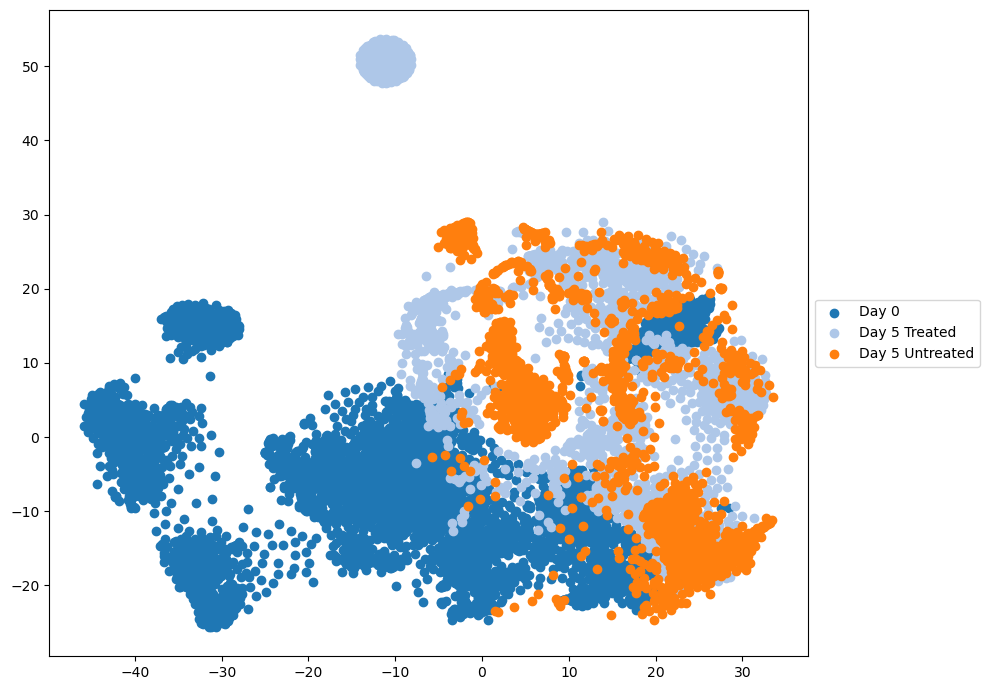

White matter


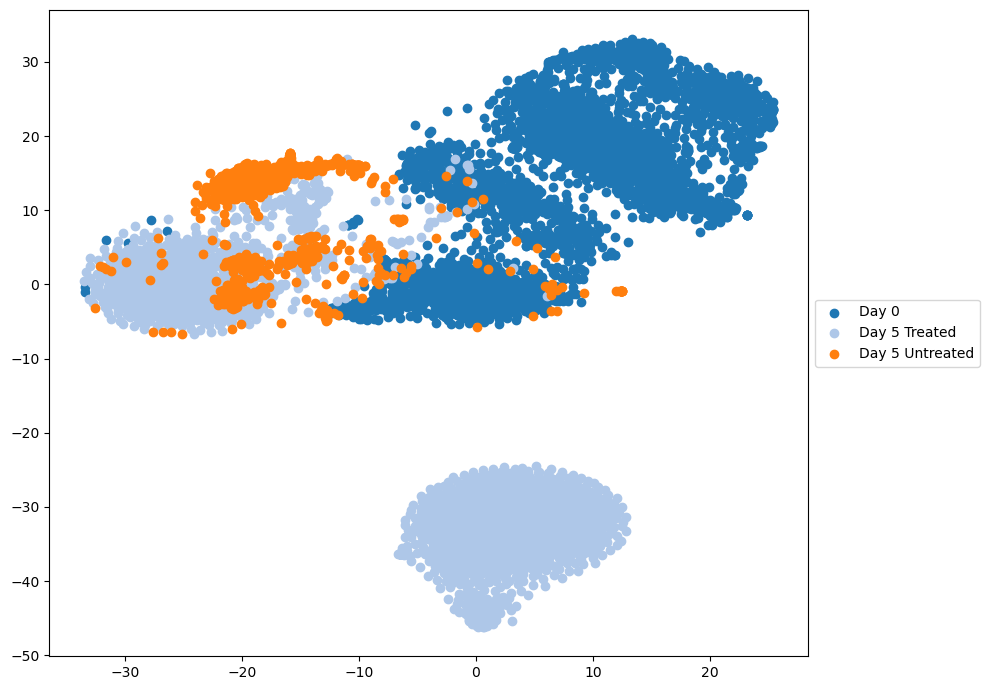

: 

In [24]:
for label in area_to_label.keys():
  tsne_data = []
  tsne_labels = []
  
  for img, cluster_labels, sample_name in zip(img_no_spatial_smoothing_list, new_cluster_labels_list, np.array(samples_groups).flatten()):
    tsne_data.append(img[cluster_labels == area_to_label.get(label)])
    if get_day(sample_name) == "0":
      tsne_labels.extend(["Day 0"] * img[cluster_labels == area_to_label.get(label)].shape[0])
    elif get_day(sample_name) == "5" and get_treatment(sample_name) == "0":
      tsne_labels.extend(["Day 5 Untreated"] * img[cluster_labels == area_to_label.get(label)].shape[0])
    else:
      tsne_labels.extend(["Day 5 Treated"] * img[cluster_labels == area_to_label.get(label)].shape[0])
  
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(np.concatenate(tsne_data))
  print(label)
  plot_embeddings(tsne_result, tsne_labels)

Tumour


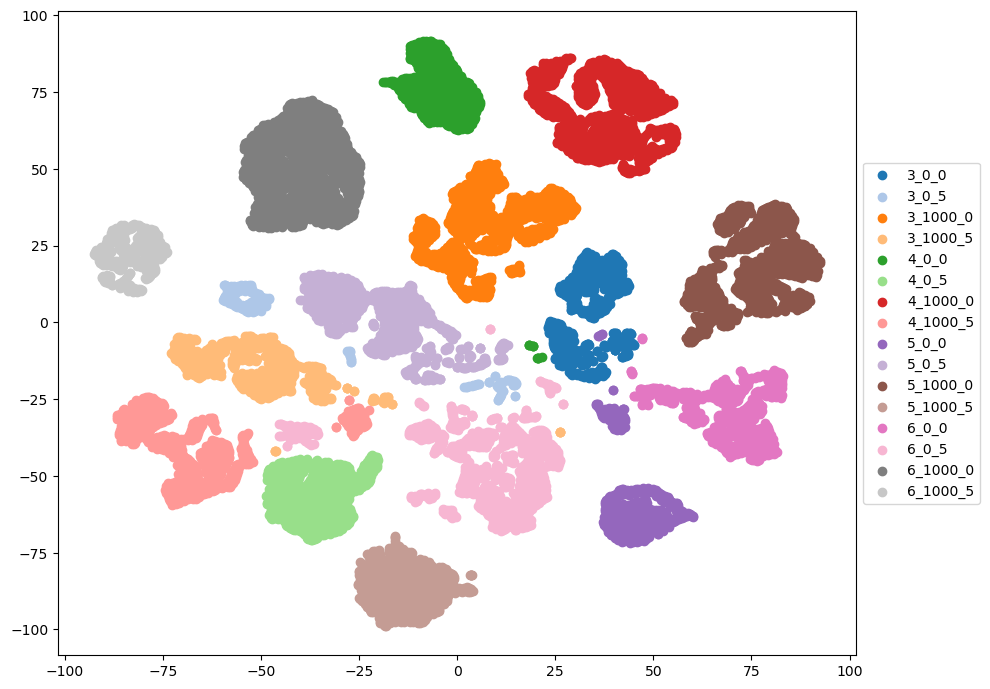

White matter


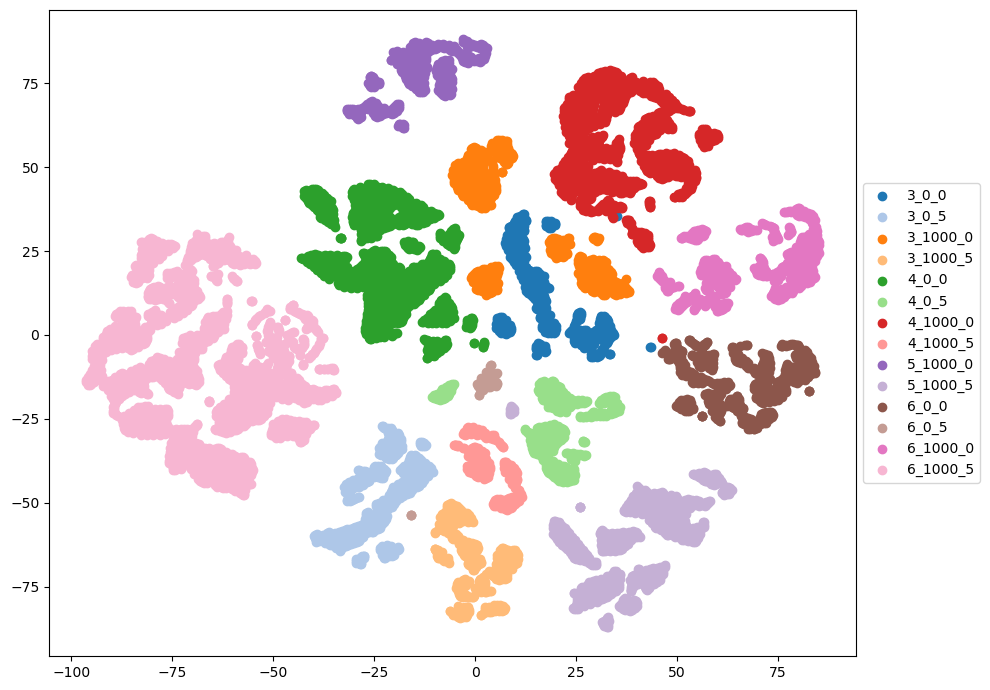

Gray matter


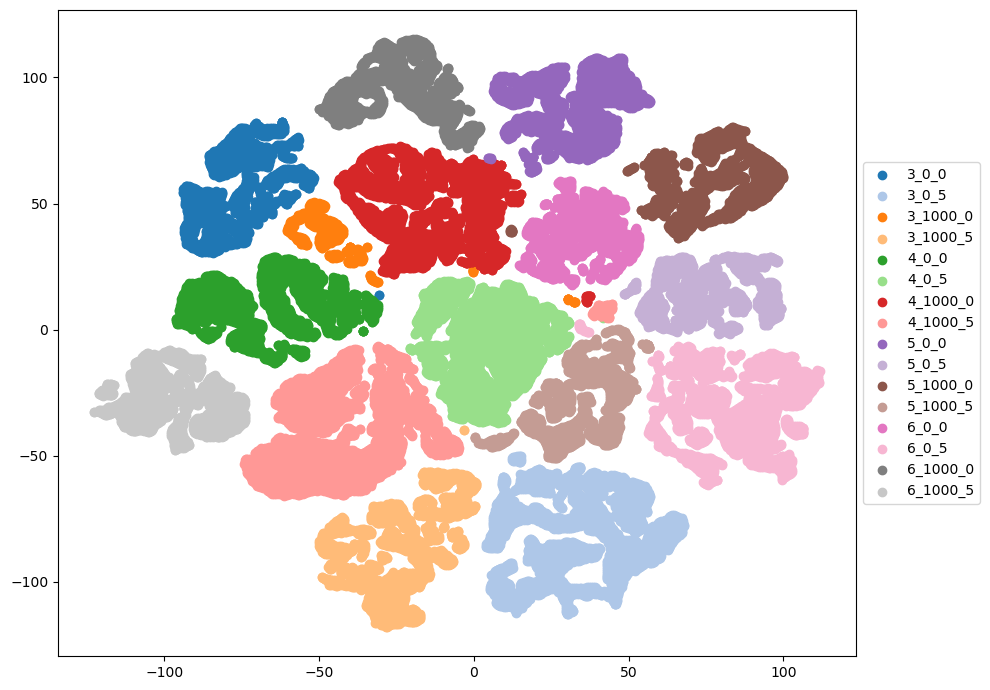

Tumour & Gray matter


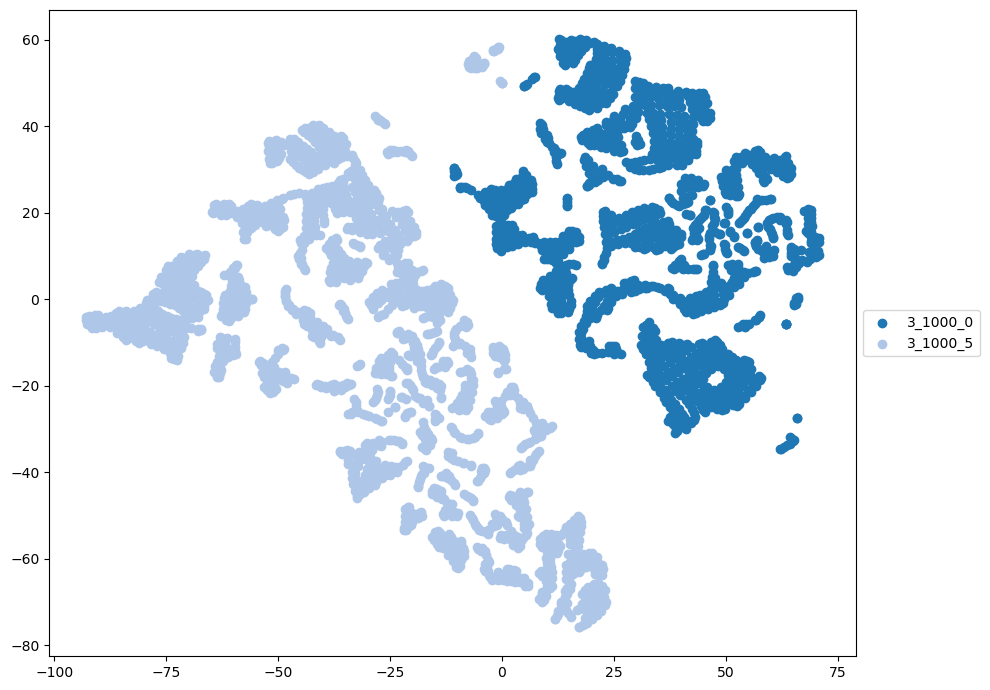

In [ ]:
for label in area_to_label.keys():
  tsne_data = []
  tsne_labels = []
  
  for img, cluster_labels, sample_name in zip(img_no_spatial_smoothing_list, new_cluster_labels_list, np.array(samples_groups).flatten()):
    tsne_data.append(img[cluster_labels == area_to_label.get(label)])
    tsne_labels.extend([f"{get_brain_id(sample_name)}_{get_treatment(sample_name)}_{get_day(sample_name)}"] * img[cluster_labels == area_to_label.get(label)].shape[0] )
    
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(np.concatenate(tsne_data))
  print(label)
  plot_embeddings(tsne_result, tsne_labels)

In [11]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

p_values_all = {}

for idx in range(0, len(samples_groups) * 2):
  tumour_vectors = img_list[idx][new_cluster_labels_list[idx] == area_to_label.get("Tumour")]
  white_matter_vectors = img_list[idx][new_cluster_labels_list[idx] == area_to_label.get("White matter")]
  gray_matter_vectors = img_list[idx][new_cluster_labels_list[idx] == area_to_label.get("Gray matter")]
  sample_name = np.array(samples_groups).flatten()[idx]


  for name, vectors in zip(["white_matter", "gray_matter"], [white_matter_vectors, gray_matter_vectors]):
    p_values = []
    for mz_idx, mz in tqdm(enumerate(mzs_list[idx])):
      t_stat_ind, p_value_ind = ttest_ind(tumour_vectors[:, mz_idx], vectors[:, mz_idx])
      p_values.append(p_value_ind)
    
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
    p_values_all[f"{get_brain_id(sample_name)}_{get_treatment(sample_name)}_{get_day(sample_name)}_{name}"] = p_values_corrected

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
pd.DataFrame(p_values_all, index=mzs_list[0]).to_csv("p_values.csv")

In [6]:
p_values_all = pd.read_csv("p_values.csv", index_col=0)

In [7]:
p_value = 0.05
significant_mzs = {}

for brain_id in [3,4,5,6]:
  for day in [0, 5]:
    for treatment in [0, 1000]:
      if np.all(np.isnan(p_values_all[f"{brain_id}_{treatment}_{day}_white_matter"])):
        significant_mzs[f"{brain_id}_{treatment}_{day}"] = ((p_values_all[f"{brain_id}_{treatment}_{day}_gray_matter"] < p_value))
      else:
        significant_mzs[f"{brain_id}_{treatment}_{day}"] = ((p_values_all[f"{brain_id}_{treatment}_{day}_white_matter"] < p_value) & (p_values_all[f"{brain_id}_{treatment}_{day}_gray_matter"] < p_value))

In [21]:
significant_not_treated_0.shape

(1,)

In [24]:
# Get significant indexes by day and treatment
significant_not_treated_0 = np.ones(p_values_all.shape[0], dtype=bool)
significant_not_treated_5 = np.ones(p_values_all.shape[0], dtype=bool)
significant_treated_0 = np.ones(p_values_all.shape[0], dtype=bool)
significant_treated_5 = np.ones(p_values_all.shape[0], dtype=bool)
for name, arr in significant_mzs.items():
  brain, treatment, day = name.split("_")
  
  if treatment == "0" and day == "0":
    significant_not_treated_0 &= arr
  elif treatment == "0" and day == "5":
    significant_not_treated_5 &= arr
  elif treatment == "1000" and day == "0":
    significant_treated_0 &= arr
  elif treatment == "1000" and day == "5":
    significant_treated_5 &= arr
  else:
    print("Error")

lipids_significant_change_df_all = []

# Indexes that are significant at Day 0 (both for treated and not treated) but 
# become non-significant at Day 5 (for both treated and not treated), which 
# means they change from significant to non-significant due to the passage of 
# time only.
became_not_significant_due_to_time  = ((significant_not_treated_0 & significant_treated_0) & ~(significant_not_treated_5 & significant_treated_5))

# Indexes that are not significant at Day 0 (both for treated and not treated) 
# but become significant at Day 5 (for both treated and not treated), which 
# means they change from non-significant to significant due to the passage of 
# time only.
became_significant_due_to_time = (~(significant_not_treated_0 & significant_treated_0) & (significant_not_treated_5 & significant_treated_5))

# Indexes that are not significant at Day 0 (both for treated and not treated) 
# and at Day 5 (for both treated and not treated), which means they dont change 
# due to the passage of time only.
stayed_non_significant_through_time = ((~significant_not_treated_0 & ~significant_not_treated_5) & (~significant_treated_0 & ~significant_treated_5))

# Indexes that are significant at Day 0 (both for treated and not treated) 
# and at Day 5 (for both treated and not treated), which means they dont change 
# due to the passage of time only.
stayed_significant_through_time = (significant_not_treated_0 & significant_treated_0 & significant_not_treated_5 & significant_treated_5)

# Indexes that are significant at Day 0 (both for treated and not treated) 
# and at Day 5 for not treated only, which means they could have change from
# due significant to non-significant due to treatment
could_have_become_not_significant_due_to_treatment = (significant_treated_0 & ~significant_treated_5 & ~became_not_significant_due_to_time)

# Indexes that are not significant at Day 0 (both for treated and not treated) 
# and at Day 5 for not treated only, which means they could have change from
# due non-significant to significant due to treatment
could_have_become_significant_due_to_treatment = (~significant_treated_0 & significant_treated_5 & ~became_significant_due_to_time)

# Check no overlap in the conditions
conditions = [
    ("became_not_significant_due_to_time", became_not_significant_due_to_time),
    ("became_significant_due_to_time", became_significant_due_to_time),
    ("stayed_non_significant_through_time", stayed_non_significant_through_time),
    ("stayed_significant_through_time", stayed_significant_through_time),
    ("could_have_become_not_significant_due_to_treatment", could_have_become_not_significant_due_to_treatment),
    ("could_have_become_significant_due_to_treatment", could_have_become_significant_due_to_treatment),
]

for i, (name1, cond1) in enumerate(conditions):
    for name2, cond2 in conditions[i + 1:]:
        intersection = (cond1 & cond2).sum()
        if intersection > 0:
            print(f"Intersection found between {name1} and {name2}: {intersection} indexes")

# Create list of reasons for significant changes
lipids_significant_changes_reason = np.array(["other"] * p_values_all.shape[0], dtype=object)
for name, bool_idx in conditions:
  lipids_significant_changes_reason[bool_idx] = name

lipids_significant_changes_df = pd.DataFrame(significant_mzs, index=p_values_all.index)
lipids_significant_changes_df[f"changes_reason"] = lipids_significant_changes_reason

In [25]:
lipids_significant_changes_df.groupby("changes_reason").size()

changes_reason
became_not_significant_due_to_time                    5703
became_significant_due_to_time                        1879
could_have_become_not_significant_due_to_treatment    2265
could_have_become_significant_due_to_treatment        2152
other                                                 5761
stayed_non_significant_through_time                   4694
stayed_significant_through_time                       1546
dtype: int64

In [68]:
lipids_significant_changes_df.groupby("changes_reason").size()

changes_reason
became_not_significant_due_to_time                    5703
became_significant_due_to_time                        1879
could_have_become_not_significant_due_to_treatment    2265
could_have_become_significant_due_to_treatment        2152
other                                                 5761
stayed_non_significant_through_time                   4694
stayed_significant_through_time                       1546
dtype: int64

In [26]:
changes_reason = "could_have_become_not_significant_due_to_treatment"
changed_mzs = lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == changes_reason].index

stored_mzs = {}

for mz in changed_mzs:
  filt = (lipids_significant_changes_df.index >= mz - 0.025) & (lipids_significant_changes_df.index <= mz + 0.025)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()
  counts.drop("other", errors="ignore", inplace=True)
  if counts.idxmax() == changes_reason and stored_mzs.get(mz) is None:
    stored_mzs[mz] = counts[changes_reason]

In [27]:
for mz, count in stored_mzs.items():
  if count >= 4:
    print(mz, count)

601.28125 5
602.29375 4
602.30625 5
602.31875 5
602.33125 4
604.25625 4
604.26875 4
604.28125 5
604.29375 4
604.30625 4
607.13125 4
607.14375 4
608.05625 4
608.06875 4
610.28125 4
610.31875 4
611.24375 4
611.25625 4
612.13125 4
613.13125 4
613.14375 4
613.15625 5
618.21875 4
619.86875 4
619.88125 5
619.89375 4
620.24375 4
620.25625 4
620.34375 4
620.35625 4
620.36875 5
620.38125 4
623.99375 4
624.34375 5
624.35625 4
624.36875 4
626.21875 5
629.24375 4
629.25625 5
629.26875 4
629.28125 4
630.30625 4
634.43125 4
634.44375 4
635.85625 4
635.86875 5
635.88125 4
640.23125 4
640.24375 5
640.25625 5
640.26875 4
640.28125 5
647.05625 4
647.06875 4
647.29375 4
647.30625 4
647.36875 4
647.38125 4
652.23125 4
652.24375 5
652.25625 4
652.35625 4
652.36875 4
653.30625 4
653.31875 5
653.33125 4
654.35625 4
654.36875 5
654.38125 5
654.39375 4
656.96875 4
658.24375 4
660.86875 4
660.88125 4
663.91875 4
663.93125 4
664.16875 4
664.18125 5
664.19375 5
664.20625 4
664.21875 5
664.24375 4
665.49375 4
665.

In [86]:
lipids_significant_changes_df[(lipids_significant_changes_df.index >= 600.25) & (lipids_significant_changes_df.index <= 600.5)].groupby("changes_reason").size()

changes_reason
became_not_significant_due_to_time                    6
became_significant_due_to_time                        3
could_have_become_not_significant_due_to_treatment    2
could_have_become_significant_due_to_treatment        2
other                                                 6
stayed_non_significant_through_time                   1
dtype: int64

In [87]:
600.21875 - 600.23125

-0.012500000000045475

In [88]:
600.23125 - 600.24375

-0.012499999999931788

In [89]:
600.24375 - 600.28125

-0.03750000000002274

In [90]:
600.28125 - 600.3062

-0.024949999999989814

In [73]:
stored_mzs

{600.21875: 6,
 600.23125: 6,
 600.24375: 6,
 600.28125: 5,
 600.30625: 5,
 602.20625: 7,
 602.21875: 7,
 602.28125: 8,
 602.29375: 8,
 602.30625: 8,
 602.31875: 7,
 602.33125: 6,
 602.34375: 6,
 602.98125: 4,
 603.01875: 4,
 604.16875: 6,
 604.19375: 8,
 604.20625: 9,
 604.24375: 10,
 604.25625: 10,
 604.26875: 10,
 604.28125: 9,
 604.29375: 9,
 604.30625: 8,
 604.31875: 7,
 604.99375: 4,
 605.00625: 4,
 605.09375: 6,
 606.85625: 3,
 607.14375: 5,
 607.15625: 6,
 607.24375: 6,
 607.25625: 5,
 607.28125: 4,
 610.25625: 7,
 610.26875: 7,
 610.28125: 7,
 610.29375: 7,
 610.31875: 7,
 610.33125: 7,
 610.34375: 7,
 611.23125: 5,
 611.24375: 5,
 611.25625: 5,
 611.26875: 5,
 611.30625: 5,
 612.10625: 7,
 612.13125: 7,
 612.14375: 6,
 612.15625: 7,
 612.19375: 7,
 612.21875: 6,
 612.25625: 4,
 613.11875: 7,
 613.13125: 7,
 613.14375: 7,
 613.15625: 7,
 613.16875: 7,
 613.18125: 7,
 613.21875: 7,
 614.21875: 5,
 614.29375: 5,
 614.90625: 6,
 614.91875: 6,
 614.94375: 6,
 614.95625: 5,
 616.19

In [59]:
paper_mzs = [
  611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45, 731.51, 
  757.53, 657.52, 773.52, 887.56, 659.50, 631.46]

for mz in sorted(paper_mzs):
  filt = (lipids_significant_changes_df.index >= mz - 0.1) & (lipids_significant_changes_df.index <= mz + 0.1)
  print(mz)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()
  counts.drop("other", errors="ignore", inplace=True)
  print(counts.idxmax())

605.45
could_have_become_significant_due_to_treatment
611.5
became_not_significant_due_to_time
631.46
became_not_significant_due_to_time
647.45
could_have_become_significant_due_to_treatment
657.52
became_not_significant_due_to_time
659.5
became_not_significant_due_to_time
682.58
became_not_significant_due_to_time
716.51
stayed_non_significant_through_time
718.53
stayed_significant_through_time
731.51
became_not_significant_due_to_time
736.64
became_not_significant_due_to_time
740.5
became_not_significant_due_to_time
757.53
became_not_significant_due_to_time
768.53
became_not_significant_due_to_time
773.52
could_have_become_significant_due_to_treatment
887.56
could_have_become_significant_due_to_treatment


In [ ]:
# 605.45, 647.45, 773.52, 887.56

In [65]:
from scipy import stats

for mz in [605.45, 647.45, 773.52, 887.56]:
  for sample_name, img, mzs, seg in zip(np.array(samples_groups).flatten(), img_list, mzs_list, seg_list):
    brain_id, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name)
    tumour_img = img[:, :, tumour_mzs_filter].mean(axis=-1)
    lipid_img = img[:, :, (mzs >= mz - 0.025) & (mzs <= mz + 0.025)].mean(axis=-1)
    print(mz, brain_id, treatment, day, stats.pearsonr(tumour_img[seg], lipid_img[seg]))

605.45 3 0 0 PearsonRResult(statistic=0.26946763401986684, pvalue=2.8054839899353295e-44)
605.45 3 0 5 PearsonRResult(statistic=0.43988777740622453, pvalue=1.9078892087864464e-173)
605.45 3 1000 0 PearsonRResult(statistic=0.5292037939986711, pvalue=5.548723597296495e-219)
605.45 3 1000 5 PearsonRResult(statistic=0.5369622315869481, pvalue=0.0)
605.45 4 0 0 PearsonRResult(statistic=0.6695330521928815, pvalue=0.0)
605.45 4 0 5 PearsonRResult(statistic=0.5930085184155318, pvalue=0.0)
605.45 4 1000 0 PearsonRResult(statistic=0.6005843918183769, pvalue=0.0)
605.45 4 1000 5 PearsonRResult(statistic=0.5958314824614316, pvalue=0.0)
605.45 5 0 0 PearsonRResult(statistic=0.49133698689822214, pvalue=2.5046395769627715e-138)
605.45 5 0 5 PearsonRResult(statistic=0.6163390130458971, pvalue=3.02147265968087e-230)
605.45 5 1000 0 PearsonRResult(statistic=0.542184769834907, pvalue=4.5710149139996154e-210)
605.45 5 1000 5 PearsonRResult(statistic=0.623972239977104, pvalue=1.6590877340921454e-288)
605.4

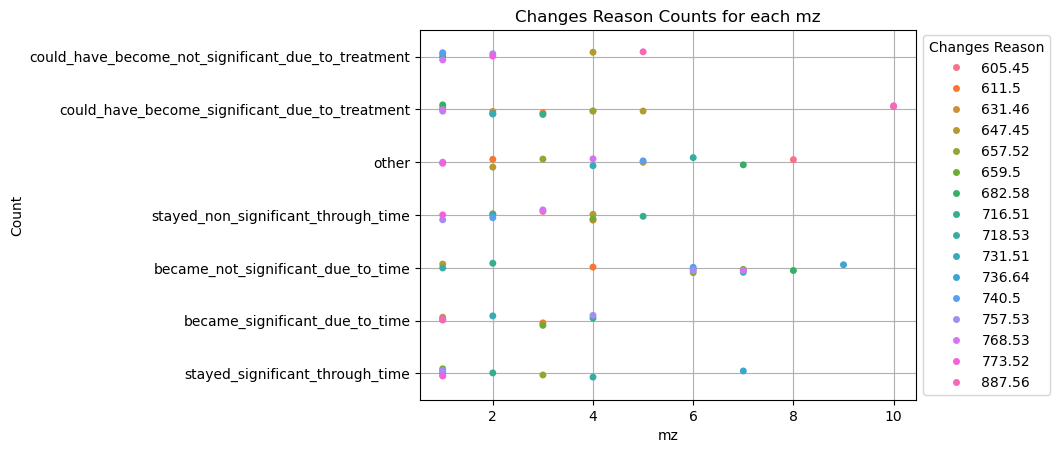

In [44]:
paper_mzs = [
  611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45, 731.51, 
  757.53, 657.52, 773.52, 887.56, 659.50, 631.46]

plot_data = []

for mz in sorted(paper_mzs):
  filt = (lipids_significant_changes_df.index >= mz - 0.1) & (lipids_significant_changes_df.index <= mz + 0.1)
  counts = lipids_significant_changes_df[filt].groupby("changes_reason").size()
  
  for reason, count in counts.items():
        plot_data.append({'mz': mz, 'changes_reason': reason, 'count': count})

plot_df = pd.DataFrame(plot_data)
plot_df['mz'] = plot_df['mz'].astype(str)
sns.stripplot(data=plot_df, y='changes_reason', x='count', hue='mz')
plt.title('Changes Reason Counts for each mz')
plt.xlabel('mz')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Changes Reason', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [28]:
paper_mzs = [
  611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45, 731.51, 
  757.53, 657.52, 773.52, 887.56, 659.50, 631.46]

# Filter the DataFrame based on the specific condition
filtered_df = lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == "could_have_become_not_significant_due_to_treatment"]

for mz in sorted(paper_mzs):
  filt = (filtered_df.index >= mz - 0.2) & (filtered_df.index <= mz + 0.2)
  if (filt).sum() > 0:
    print(f"Identified lipid: {mz}, Changed lipids: {filtered_df[filt].index.to_list()}")

Identified lipid: 605.45, Changed lipids: [605.49375]
Identified lipid: 647.45, Changed lipids: [647.29375, 647.38125, 647.44375, 647.45625, 647.48125]
Identified lipid: 657.52, Changed lipids: [657.34375, 657.36875, 657.38125, 657.39375]
Identified lipid: 659.5, Changed lipids: [659.33125, 659.34375, 659.36875]
Identified lipid: 716.51, Changed lipids: [716.36875, 716.38125, 716.39375, 716.40625]
Identified lipid: 718.53, Changed lipids: [718.40625, 718.59375]
Identified lipid: 731.51, Changed lipids: [731.38125, 731.39375]
Identified lipid: 736.64, Changed lipids: [736.51875]
Identified lipid: 740.5, Changed lipids: [740.45625]
Identified lipid: 757.53, Changed lipids: [757.44375, 757.45625, 757.63125, 757.64375]
Identified lipid: 768.53, Changed lipids: [768.50625]
Identified lipid: 773.52, Changed lipids: [773.33125, 773.34375, 773.44375, 773.45625, 773.63125]
Identified lipid: 887.56, Changed lipids: [887.41875, 887.43125, 887.48125, 887.49375, 887.50625, 887.63125, 887.64375]


In [ ]:
conditions = [
    ("became_not_significant_due_to_time", became_not_significant_due_to_time),
    ("became_significant_due_to_time", became_significant_due_to_time),
    ("stayed_non_significant_through_time", stayed_non_significant_through_time),
    ("stayed_significant_through_time", stayed_significant_through_time),
    ("could_have_become_not_significant_due_to_treatment", could_have_become_not_significant_due_to_treatment),
    ("could_have_become_significant_due_to_treatment", could_have_become_significant_due_to_treatment),
]

In [82]:
filtered_df = lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == "could_have_become_not_significant_due_to_treatment"]


# Round the index values
rounded_indices = np.round(filtered_df.index.to_list())

# Get unique rounded indices and their counts
unique_indices, counts = np.unique(rounded_indices, return_counts=True)

# Sort the counts in descending order and get the top 20
sorted_order = sorted(np.argsort(counts)[::-1][:])

# Get the top 20 rounded indices
top_20_rounded_indices = unique_indices[sorted_order]
top_20_counts = counts[sorted_order]

# Get the original index values corresponding to these top 20 rounded indices
original_indices = []
for rounded_idx in top_20_rounded_indices:
    original_idx_values = filtered_df.index[np.round(filtered_df.index.to_list()) == rounded_idx].to_list()
    original_indices.append(original_idx_values)

# Print the top 20 rounded indices and their original index values
for rounded_idx, count, orig_idx_list in zip(top_20_rounded_indices, top_20_counts, original_indices):
    print(f"Lipid: {rounded_idx}, Lipids in its range: {orig_idx_list}")
    print(count)

Lipid: 600.0, Lipids in its range: [600.25625, 600.26875]
2
Lipid: 601.0, Lipids in its range: [601.28125, 601.30625]
2
Lipid: 602.0, Lipids in its range: [602.20625, 602.21875, 602.23125, 602.29375, 602.30625, 602.31875, 602.33125]
7
Lipid: 603.0, Lipids in its range: [603.48125, 603.49375]
2
Lipid: 604.0, Lipids in its range: [604.21875, 604.23125, 604.24375, 604.25625, 604.26875]
5
Lipid: 605.0, Lipids in its range: [605.00625, 605.43125, 605.44375, 605.45625, 605.49375]
5
Lipid: 606.0, Lipids in its range: [606.44375, 606.45625]
2
Lipid: 608.0, Lipids in its range: [607.53125, 608.28125, 608.29375, 608.30625, 608.31875, 608.33125, 608.34375]
7
Lipid: 609.0, Lipids in its range: [608.54375, 609.30625]
2
Lipid: 610.0, Lipids in its range: [609.53125, 609.54375, 609.55625, 610.21875, 610.23125, 610.24375, 610.25625, 610.26875]
8
Lipid: 611.0, Lipids in its range: [611.25625, 611.41875]
2
Lipid: 612.0, Lipids in its range: [611.58125, 611.59375, 612.21875, 612.23125, 612.24375]
5
Lipid

In [87]:
605.43125 - 605.45

-0.018750000000068212

In [84]:
conditions = [
"became_not_significant_due_to_time"
]

In [85]:
for rounded_idx in top_20_rounded_indices:
  sums = []
  for condition in conditions:
    filtered_df = lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == condition]
    filt = (np.round(filtered_df.index.to_list()) == rounded_idx)
    sums.append(filt.sum())
  if np.sum(sums) == 0:
    print(rounded_idx)

612.0
750.0
786.0
803.0
861.0
865.0
887.0


In [12]:
for i in top_20_rounded_indices:
  if i-1 in top_20_rounded_indices:
    print(i-1)
  if i+1 in top_20_rounded_indices:
    print(i+1)

687.0
686.0
688.0
687.0
860.0
859.0
874.0
873.0
875.0
874.0
891.0
890.0


In [73]:
print(lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == "could_have_become_not_significant_due_to_treatment"].index.to_list())

[600.25625, 600.26875, 601.28125, 601.30625, 602.20625, 602.21875, 602.23125, 602.29375, 602.30625, 602.31875, 602.33125, 603.48125, 603.49375, 604.21875, 604.23125, 604.24375, 604.25625, 604.26875, 605.00625, 605.43125, 605.44375, 605.45625, 605.49375, 606.44375, 606.45625, 607.53125, 608.28125, 608.29375, 608.30625, 608.31875, 608.33125, 608.34375, 608.54375, 609.30625, 609.53125, 609.54375, 609.55625, 610.21875, 610.23125, 610.24375, 610.25625, 610.26875, 611.25625, 611.41875, 611.58125, 611.59375, 612.21875, 612.23125, 612.24375, 613.23125, 613.25625, 613.53125, 613.54375, 613.55625, 615.48125, 615.50625, 615.51875, 615.53125, 615.54375, 616.44375, 617.08125, 617.50625, 617.51875, 617.53125, 617.71875, 618.35625, 619.49375, 619.50625, 619.51875, 619.76875, 620.35625, 620.48125, 620.49375, 620.50625, 621.50625, 621.51875, 621.69375, 621.70625, 621.75625, 621.76875, 622.35625, 622.36875, 622.50625, 623.53125, 623.54375, 623.55625, 623.73125, 624.31875, 624.33125, 624.34375, 624.51875

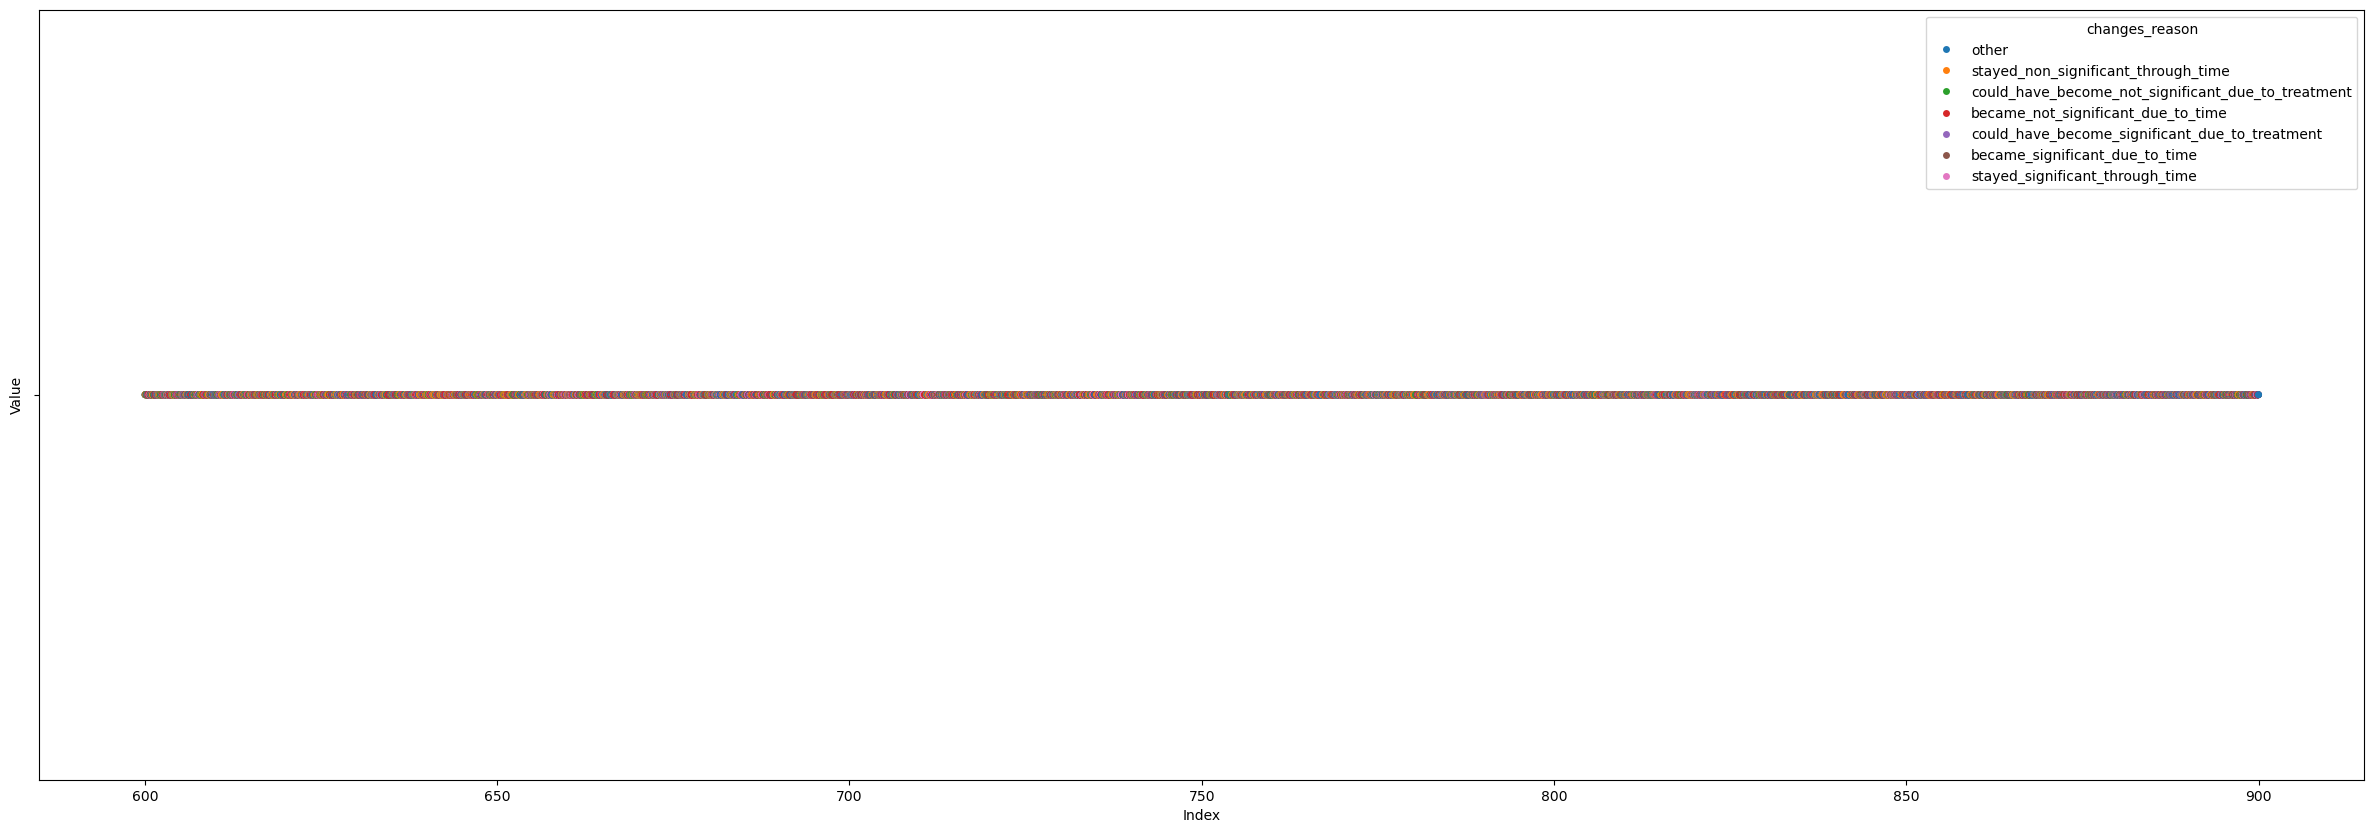

In [43]:
# Create the scatter plot using the index directly
plt.figure(figsize=(30, 10))
sns.stripplot(x=lipids_significant_changes_df.index.to_list(), hue=lipids_significant_changes_df['changes_reason'], jitter=0)

# Add titles and labels
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()

In [24]:
lipids_significant_changes_df

index  3_0_0  3_1000_0  3_0_5  3_1000_5  4_0_0  4_1000_0  4_0_5  \
0      600.00625   True     False  False      True   True      True  False   
1      600.01875   True     False  False      True   True      True  False   
2      600.03125   True     False  False      True  False     False  False   
3      600.04375   True      True  False      True  False      True   True   
4      600.05625   True      True  False      True  False      True   True   
...          ...    ...       ...    ...       ...    ...       ...    ...   
23995  899.94375   True      True   True      True   True      True   True   
23996  899.95625   True      True   True      True   True      True   True   
23997  899.96875   True      True   True      True   True      True   True   
23998  899.98125   True      True   True      True  False      True   True   
23999  899.99375   True      True   True      True  False      True   True   

       4_1000_5  5_0_0  5_1000_0  5_0_5  5_1000_5  6_0_0  6_1000_0  6_0_5  \
0         False   True      True   True      True   True      True   True   
1         False   True      True   True      True   True      True   True   
2         False   True      True   True     False   True      True  False   
3         False   True      True   True     False   True      True  False   
4         False   True     False   True      True  False      True  False   
...         ...    ...       ...    ...       ...    ...       ...    ...   
23995     False   True      True   True     False   True      True   True   
23996     False   True      True   True     False   True      True   True   
23997     False   True      True   True      True   True      True   True   
23998     False   True      True   True      True   True     False   True   
23999     False   True      True   True      True   True     False   True   

       6_1000_5                                     changes_reason  
0          True                                              other  
1          True                                              other  
2         False                stayed_non_significant_through_time  
3          True  could_have_become_not_significant_due_to_treat...  
4          True                stayed_non_significant_through_time  
...         ...                                                ...  
23995      True                 became_not_significant_due_to_time  
23996      True                 became_not_significant_due_to_time  
23997     False                 became_not_significant_due_to_time  
23998     False                                              other  
23999     False                                              other  

[24000 rows x 18 columns]

In [22]:
lipids_significant_changes_df[lipids_significant_changes_df["changes_reason"] == "could_have_become_not_significant_due_to_treatment"].index.to_list()

[600.04375,
 600.14375,
 600.21875,
 600.23125,
 600.24375,
 600.28125,
 600.30625,
 600.79375,
 600.80625,
 600.81875,
 600.85625,
 600.99375,
 601.00625,
 601.03125,
 601.25625,
 601.26875,
 601.28125,
 601.29375,
 601.30625,
 601.48125,
 601.79375,
 601.93125,
 602.04375,
 602.10625,
 602.11875,
 602.20625,
 602.21875,
 602.28125,
 602.29375,
 602.30625,
 602.31875,
 602.33125,
 602.34375,
 602.91875,
 602.98125,
 603.01875,
 603.03125,
 603.31875,
 603.85625,
 603.86875,
 603.93125,
 603.94375,
 604.03125,
 604.16875,
 604.19375,
 604.20625,
 604.24375,
 604.25625,
 604.26875,
 604.28125,
 604.29375,
 604.30625,
 604.31875,
 604.99375,
 605.00625,
 605.01875,
 605.09375,
 605.14375,
 605.15625,
 605.73125,
 605.74375,
 606.13125,
 606.14375,
 606.15625,
 606.31875,
 606.44375,
 606.85625,
 606.86875,
 606.91875,
 607.11875,
 607.13125,
 607.14375,
 607.15625,
 607.24375,
 607.25625,
 607.28125,
 607.29375,
 607.40625,
 607.54375,
 607.88125,
 607.89375,
 607.91875,
 607.93125,
 608

In [ ]:
###############################################################################

In [53]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(np.concatenate([img[seg] for img, seg in zip(img_no_spatial_smoothing_list, seg_list)]))

In [54]:
import joblib
joblib.dump(tsne,  "tsne_meaningful_no_spatial_smoothing.pkl")

['tsne_meaningful_no_spatial_smoothing.pkl']

In [44]:
tsne = joblib.load("tsne_meaningful_processed.pkl")
tsne_result = tsne.embedding_

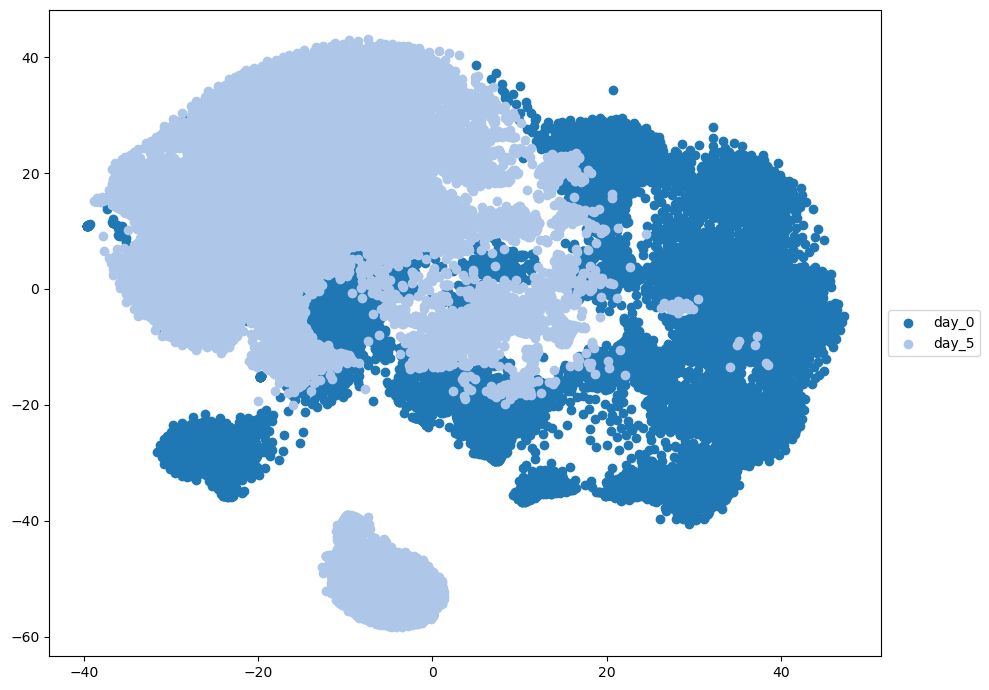

In [58]:
plot_embeddings(tsne_result, np.concatenate([["day_0"] * img[seg].shape[0] if idx % 2 == 0 else ["day_5"] * img[seg].shape[0] for idx, (img, seg) in enumerate(zip(img_list, seg_list))]))

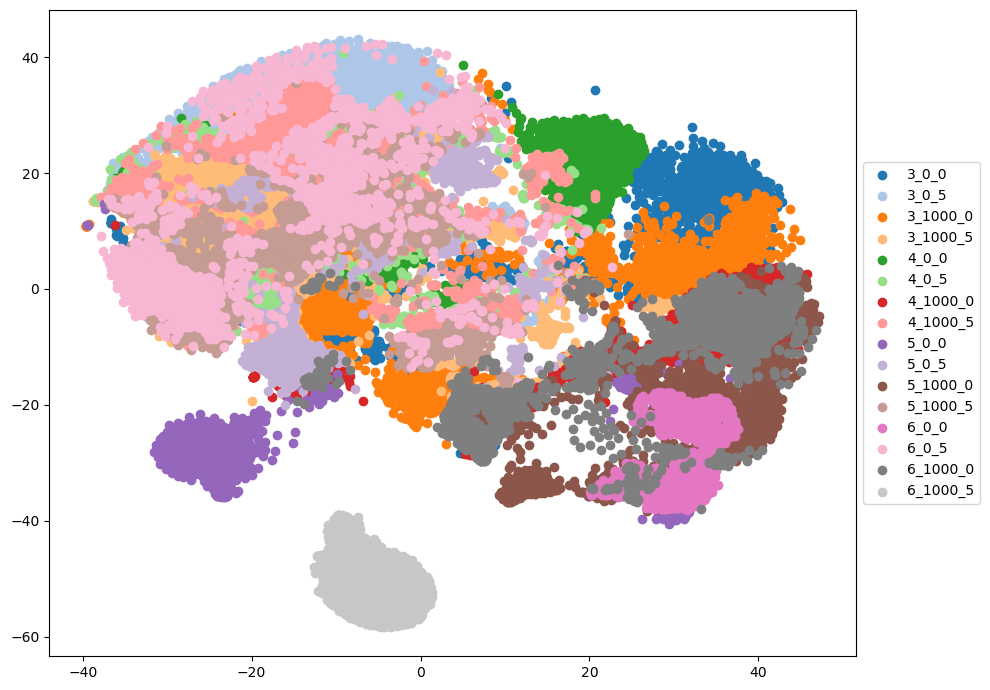

In [59]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_brain_id(sample)}_{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

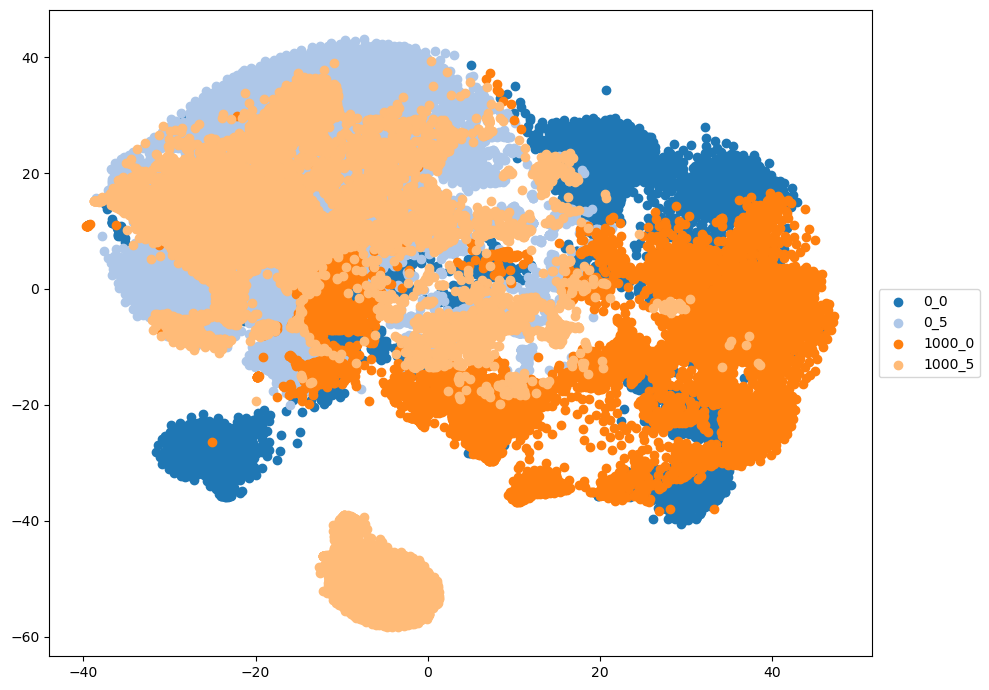

In [60]:
plot_embeddings(tsne_result, np.concatenate([[f"{get_treatment(sample)}_{get_day(sample)}"] * img[seg].shape[0] for idx, (img, seg, sample) in enumerate(zip(img_list, seg_list, np.array(samples_groups).flatten()))]))

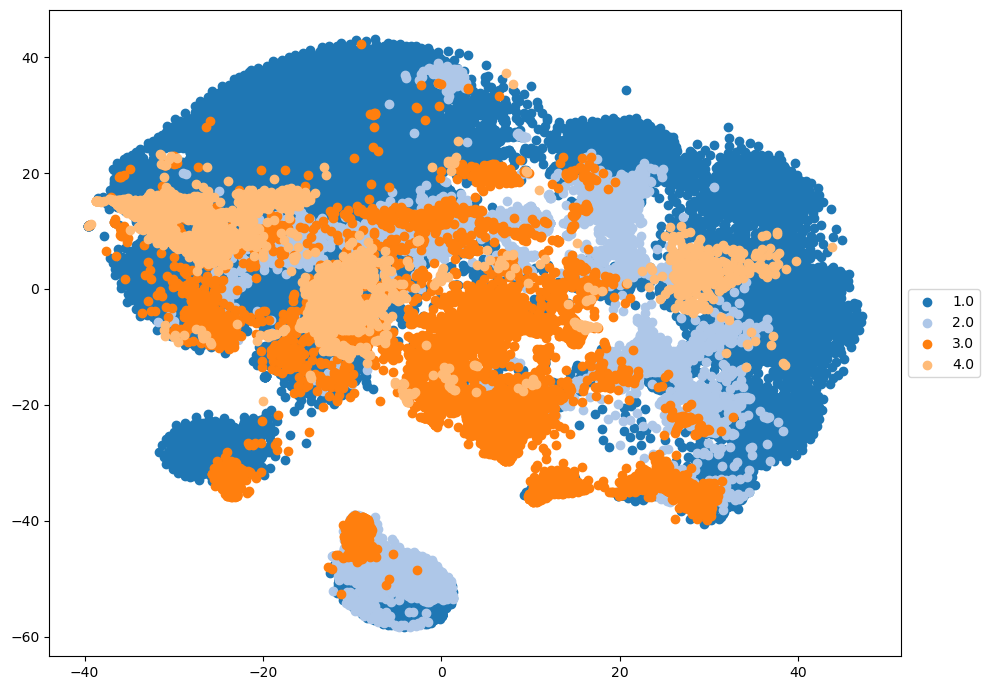

In [61]:
plot_embeddings(tsne_result, np.concatenate([ new_cluster_labels[seg].flatten() for idx, (img, seg, new_cluster_labels) in enumerate(zip(img_list, seg_list, new_cluster_labels_list))]))

In [62]:
start_idx = 0

tsne_embedding_list = []

for img, seg in zip(img_list, seg_list):
  num_spectras = img[seg].shape[0]
  tsne_embedding_list.append(tsne_result[start_idx:start_idx + num_spectras])
  start_idx += num_spectras

Gray matter


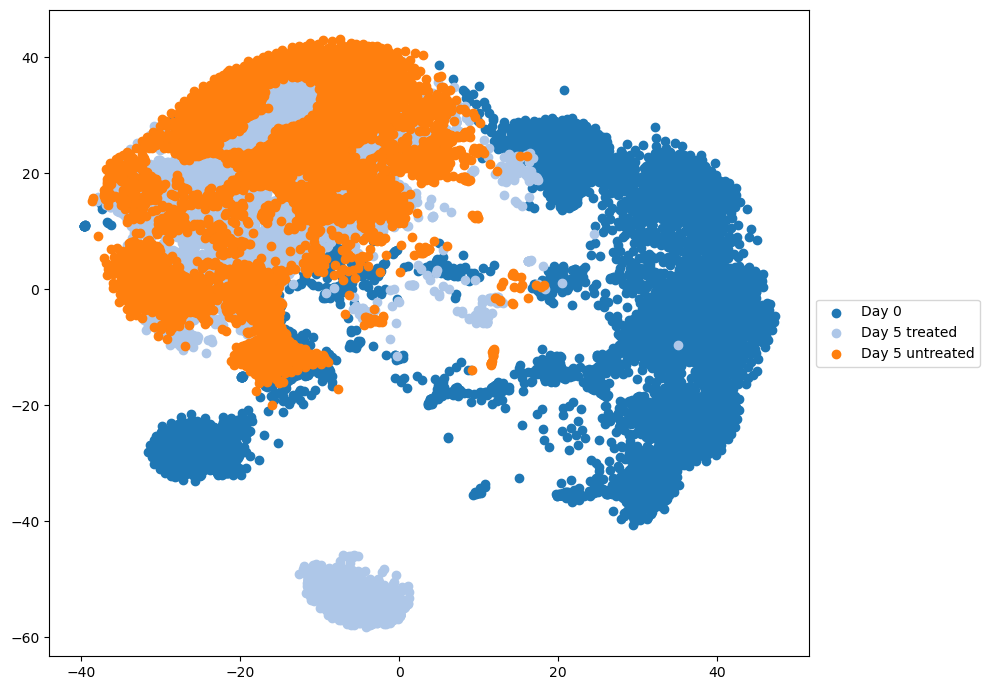

White matter


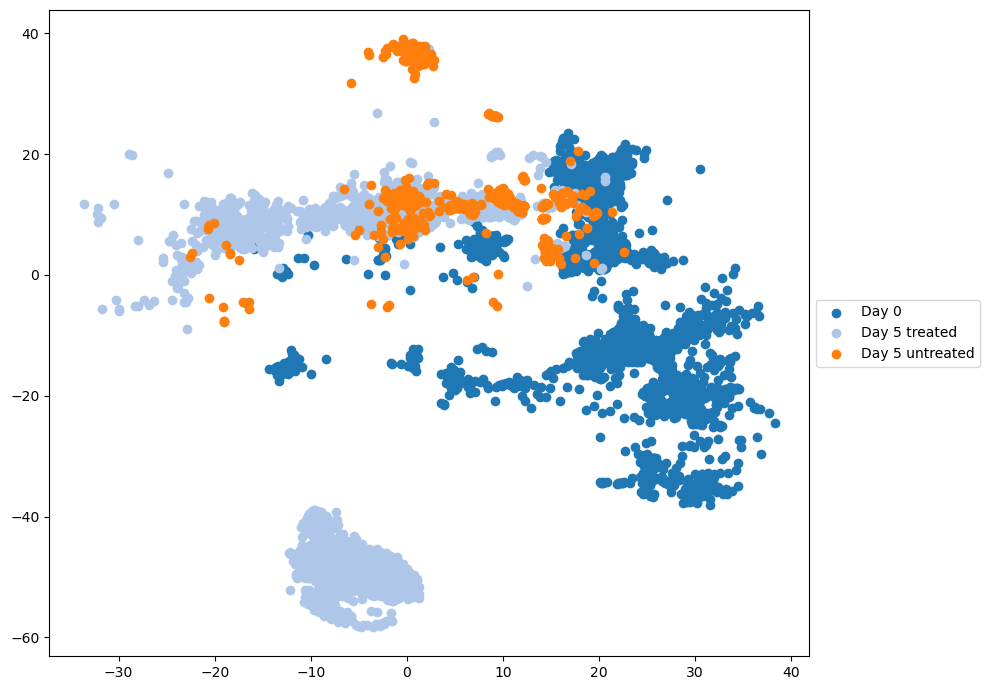

Tumour


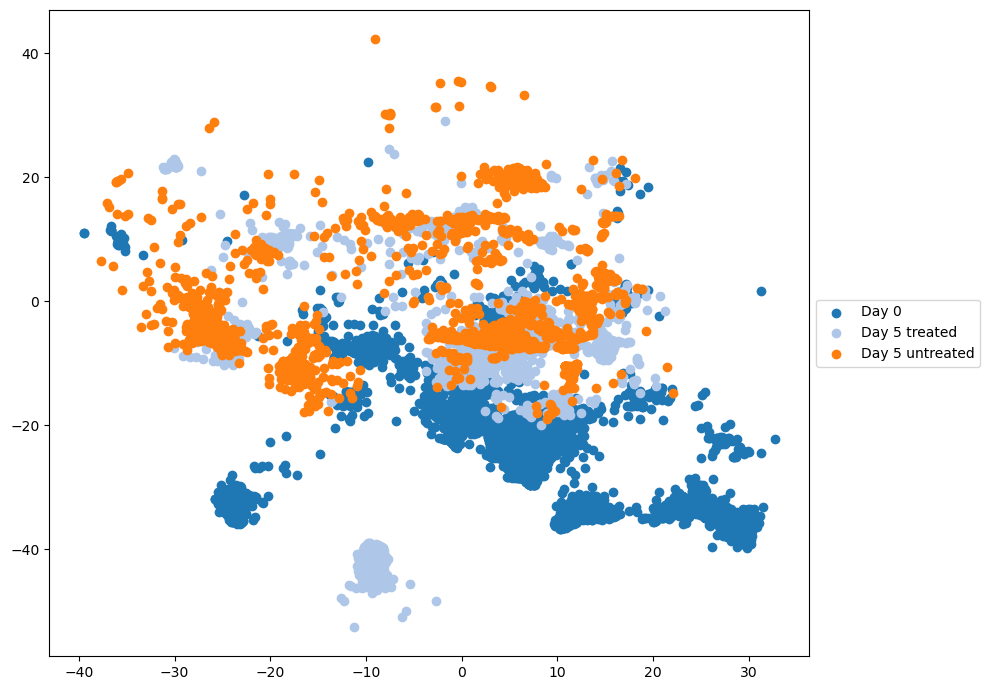

In [63]:
label_to_area = dict((v, k) for k, v in area_to_label.items())

for label in [1,2,3]:
  tsne_l_results = []
  labels_l = []
  for idx, (img, seg, new_cluster_labels, tsne_embedding) in enumerate(zip(img_list, seg_list, new_cluster_labels_list, tsne_embedding_list)):
    if label in new_cluster_labels:
      sample_name = np.array(samples_groups).flatten()[idx]
      brain, treatment, day = get_brain_id(sample_name), get_treatment(sample_name), get_day(sample_name)
      tsne_l_results.extend(tsne_embedding[new_cluster_labels[seg]  == label])
      if day == "0":
        labels_l.extend(["Day 0"] * tsne_embedding[new_cluster_labels[seg] == label].shape[0])
      elif treatment == "0":
        labels_l.extend(["Day 5 untreated"] * tsne_embedding[new_cluster_labels[seg]  == label].shape[0])
      else:
        labels_l.extend(["Day 5 treated "] * tsne_embedding[new_cluster_labels[seg]  == label].shape[0])
  
  print(label_to_area[label])
  plot_embeddings(tsne_l_results, labels_l)

In [41]:
# Apply tsne per cluster group

['tsne_meaningful.pkl']

In [13]:
# Calculate mean vector for each cluster in each img

mean_vecs = {}
for idx, (img, new_cluster_labels) in enumerate(zip(img_list, new_cluster_labels_list)):
  mean_vecs[idx] = {}
  for name, label in area_to_label.items():
    if "&" not in name:
      if label in new_cluster_labels:
        mean_vecs[idx][name] = img[new_cluster_labels == label].mean(axis=0)

In [222]:
thresh = 0.9
lipids_significant_change_df_all = []

for area, loop_filter in zip(
  ["Tumour", "White matter", "Gray matter"], 
  [tumour_mzs_filter, white_matter_mzs_filter, gray_matter_mzs_filter]):

  # Get significant indexes in each mean vector
  significant_idx = {}

  for idx in range(0, len(mean_vecs)):
    if area not in mean_vecs[idx]:
      continue
    mean_tumour = mean_vecs[idx][area]
    l_thresh = mean_tumour[loop_filter].min() * thresh
    significant_idx[idx] = mean_tumour >= l_thresh

  # Get significant indexes by day and treatment
  significant_not_treated_0 = np.ones_like(loop_filter, dtype=bool)
  significant_not_treated_5 = np.ones_like(loop_filter, dtype=bool)
  significant_treated_0 = np.ones_like(loop_filter, dtype=bool)
  significant_treated_5 = np.ones_like(loop_filter, dtype=bool)
  for idx, arr in significant_idx.items():
    sample_name = np.array(samples_groups).flatten()[idx]
    treatment, day = get_treatment(sample_name), get_day(sample_name)
    
    if treatment == "0" and day == "0":
      significant_not_treated_0 &= arr
    elif treatment == "0" and day == "5":
      significant_not_treated_5 &= arr
    elif treatment == "1000" and day == "0":
      significant_treated_0 &= arr
    elif treatment == "1000" and day == "5":
      significant_treated_5 &= arr
    else:
      print("Error")

  # Indexes that are significant at Day 0 (both for treated and not treated) but 
  # become non-significant at Day 5 (for both treated and not treated), which 
  # means they change from significant to non-significant due to the passage of 
  # time only.
  became_not_significant_due_to_time  = ((significant_not_treated_0 & significant_treated_0) & ~(significant_not_treated_5 & significant_treated_5))

  # Indexes that are not significant at Day 0 (both for treated and not treated) 
  # but become significant at Day 5 (for both treated and not treated), which 
  # means they change from non-significant to significant due to the passage of 
  # time only.
  became_significant_due_to_time = (~(significant_not_treated_0 & significant_treated_0) & (significant_not_treated_5 & significant_treated_5))

  # Indexes that are not significant at Day 0 (both for treated and not treated) 
  # and at Day 5 (for both treated and not treated), which means they dont change 
  # due to the passage of time only.
  stayed_non_significant_through_time = ((~significant_not_treated_0 & ~significant_not_treated_5) & (~significant_treated_0 & ~significant_treated_5))

  # Indexes that are significant at Day 0 (both for treated and not treated) 
  # and at Day 5 (for both treated and not treated), which means they dont change 
  # due to the passage of time only.
  stayed_significant_through_time = (significant_not_treated_0 & significant_treated_0 & significant_not_treated_5 & significant_treated_5)

  # Indexes that are significant at Day 0 (both for treated and not treated) 
  # and at Day 5 for not treated only, which means they could have change from
  # due significant to non-significant due to treatment
  could_have_become_not_significant_due_to_treatment = (significant_treated_0 & ~significant_treated_5 & ~became_not_significant_due_to_time)

  # Indexes that are not significant at Day 0 (both for treated and not treated) 
  # and at Day 5 for not treated only, which means they could have change from
  # due non-significant to significant due to treatment
  could_have_become_significant_due_to_treatment = (~significant_treated_0 & significant_treated_5 & ~became_significant_due_to_time)
  
  # Check no overlap in the conditions
  conditions = [
      ("became_not_significant_due_to_time", became_not_significant_due_to_time),
      ("became_significant_due_to_time", became_significant_due_to_time),
      ("stayed_non_significant_through_time", stayed_non_significant_through_time),
      ("stayed_significant_through_time", stayed_significant_through_time),
      ("could_have_become_not_significant_due_to_treatment", could_have_become_not_significant_due_to_treatment),
      ("could_have_become_significant_due_to_treatment", could_have_become_significant_due_to_treatment),
  ]

  for i, (name1, cond1) in enumerate(conditions):
      for name2, cond2 in conditions[i + 1:]:
          intersection = (cond1 & cond2).sum()
          if intersection > 0:
              print(f"Intersection found between {name1} and {name2}: {intersection} indexes")

  # Create list of reasons for significant changes
  lipids_significant_changes_reason = np.array(["other"] * mzs_list[0].shape[0], dtype=object)
  for name, bool_idx in conditions:
    lipids_significant_changes_reason[bool_idx] = name

  lipids_significant_changes_df = pd.DataFrame(significant_idx, index=mzs_list[0])
  lipids_significant_changes_df.columns = lipids_significant_changes_df.columns.map(lambda x: np.array(samples_groups).flatten()[x]).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}_{area}")
  lipids_significant_changes_df[f"changes_reason_{area}"] = lipids_significant_changes_reason

  lipids_significant_change_df_all.append(lipids_significant_changes_df)

In [223]:
lipids_significant_change_single_df= pd.concat(lipids_significant_change_df_all, axis=1)

In [240]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('could_have_become_not_significant_due_to_treatment').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('stayed_non_significant_through_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('stayed_non_significant_through_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[621.63125, 623.63125, 628.65625, 649.61875, 649.63125, 649.65625, 651.61875, 663.53125, 666.61875, 667.61875, 667.63125, 669.65625, 672.65625, 684.53125, 684.59375, 684.61875, 684.63125, 684.65625, 685.61875, 738.55625, 738.56875, 738.65625, 739.55625, 739.56875, 739.65625, 739.68125, 760.63125, 780.46875, 795.68125, 797.46875, 798.44375, 799.44375, 812.44375, 814.43125, 815.46875, 824.43125, 830.40625, 830.43125, 838.38125, 851.43125, 855.40625, 855.43125, 855.44375, 855.45625, 856.40625, 857.40625, 858.40625, 866.40625, 866.41875, 870.40625, 873.38125, 873.40625, 873.43125, 874.41875, 877.45625, 882.38125, 882.41875, 884.38125, 892.40625, 896.34375, 896.36875, 896.90625, 896.93125]


In [232]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('could_have_become_significant_due_to_treatment').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('stayed_non_significant_through_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('stayed_non_significant_through_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[603.43125, 603.44375, 604.46875, 605.46875, 606.49375, 611.46875, 617.44375, 631.49375, 631.50625, 632.49375, 632.50625, 633.46875, 633.49375, 633.50625, 633.53125, 656.53125, 658.55625, 658.56875, 658.59375, 659.55625, 659.56875, 681.55625, 682.53125, 682.58125, 683.60625, 709.55625, 709.56875, 711.56875, 712.46875, 715.61875, 716.63125, 731.58125, 739.59375, 740.63125, 741.59375, 741.63125, 760.59375, 769.65625, 795.49375, 868.71875, 895.75625, 895.78125, 896.74375, 896.75625, 896.78125, 897.74375, 897.75625, 897.78125]


In [258]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('could_have_become_not_significant_due_to_treatment').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('stayed_significant_through_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('stayed_significant_through_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[]


In [259]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('could_have_become_significant_due_to_treatment').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('stayed_significant_through_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('stayed_significant_through_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[]


In [264]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('became_not_significant_due_to_time').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('became_not_significant_due_to_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('became_not_significant_due_to_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[879.49375, 880.46875, 896.46875]


In [263]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('became_significant_due_to_time').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('became_significant_due_to_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('became_significant_due_to_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())

[]


In [266]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Tumour').eq('stayed_non_significant_through_time').any(axis=1)
]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_Gray matter').eq('stayed_non_significant_through_time').any(axis=1)
]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(like='changes_reason_White matter').eq('stayed_non_significant_through_time').any(axis=1)
]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())
print(len(common_lipids.tolist()))

[600.00625, 600.01875, 600.03125, 600.04375, 600.05625, 600.06875, 600.08125, 600.09375, 600.10625, 600.11875, 600.13125, 600.14375, 600.15625, 600.16875, 600.18125, 600.19375, 600.20625, 600.21875, 600.23125, 600.24375, 600.25625, 600.26875, 600.28125, 600.29375, 600.30625, 600.33125, 600.35625, 600.36875, 600.38125, 600.39375, 600.41875, 600.45625, 600.66875, 600.70625, 600.73125, 600.76875, 600.79375, 600.83125, 600.85625, 600.89375, 600.91875, 600.95625, 600.96875, 600.98125, 600.99375, 601.00625, 601.01875, 601.04375, 601.08125, 601.10625, 601.11875, 601.13125, 601.14375, 601.15625, 601.16875, 601.18125, 601.19375, 601.20625, 601.21875, 601.23125, 601.24375, 601.25625, 601.26875, 601.29375, 601.30625, 601.31875, 601.33125, 601.34375, 601.35625, 601.36875, 601.38125, 601.39375, 601.40625, 601.41875, 601.44375, 601.45625, 601.46875, 601.64375, 601.66875, 601.70625, 601.71875, 601.73125, 601.74375, 601.75625, 601.76875, 601.78125, 601.79375, 601.81875, 601.83125, 601.84375, 601.85625

In [268]:
a = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Tumour'
    ).eq('stayed_significant_through_time').any(axis=1)]

b = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_Gray matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

c = lipids_significant_change_single_df.index[
    lipids_significant_change_single_df.filter(
        like='changes_reason_White matter'
    ).eq('stayed_significant_through_time').any(axis=1)]

common_lipids = a.intersection(b).intersection(c)

print(common_lipids.tolist())
print(len(common_lipids.tolist()))

[]
0


In [68]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind, permutation_test, mannwhitneyu, cramervonmises_2samp

p_values_all = {}

def diff_mean(x, y):
  return np.mean(x) - np.mean(y)

for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  vecs_0 = img_original_list[img_idx][seg_list[img_idx]]
  vecs_5 = img_original_list[img_idx + 1][seg_list[img_idx + 1]]

  p_values = []

  for mz_idx, mz in tqdm(enumerate(mzs_list[0])):
    values_0 = vecs_0[:, mz_idx].flatten()
    values_5 = vecs_5[:, mz_idx].flatten()
    #t_stat_ind, p_value_ind = ttest_ind(values_0, values_5)
    # t_stat_ind, p_value_ind = mannwhitneyu(values_0, values_5)
    result = cramervonmises_2samp(values_0, values_5)

    # cramervonmises_2samp

    #result = permutation_test((values_0, values_5), diff_mean, permutation_type='independent', alternative='two-sided', n_resamples=10000, random_state=42)
    p_value_ind = result.pvalue
    p_values.append(p_value_ind)
  
  p_values_all[img_idx] = p_values

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [69]:
columns = []
for img_idx in tqdm(range(0, len(samples_groups) * 2, 2)):
  sample = np.array(samples_groups).flatten()[img_idx]
  brain, treatment, day = get_brain_id(sample), get_treatment(sample), get_day(sample)
  columns.append(f"{brain}_{treatment}_{day}")

  0%|          | 0/8 [00:00<?, ?it/s]

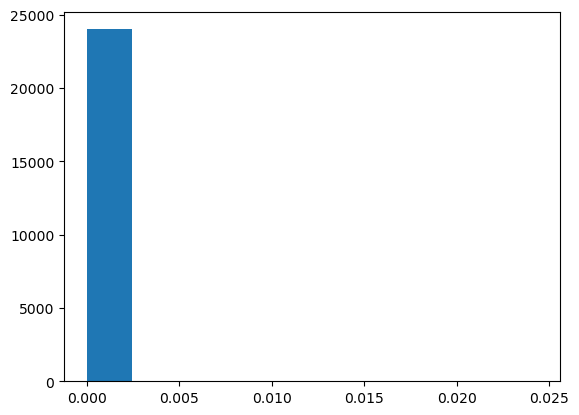

1.0


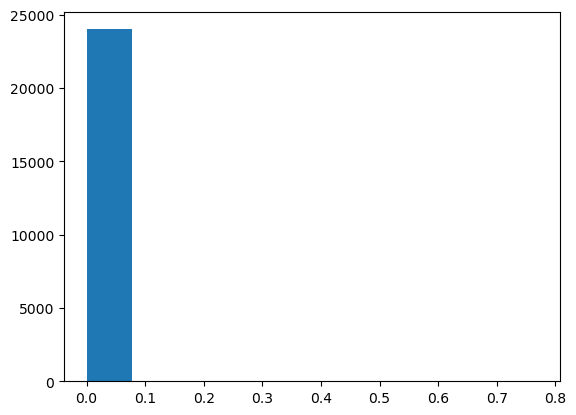

0.9998333333333334


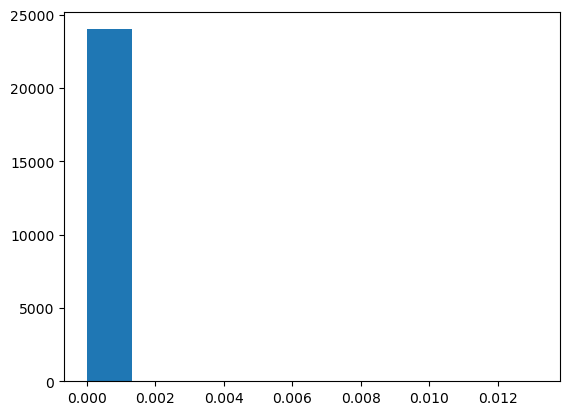

1.0


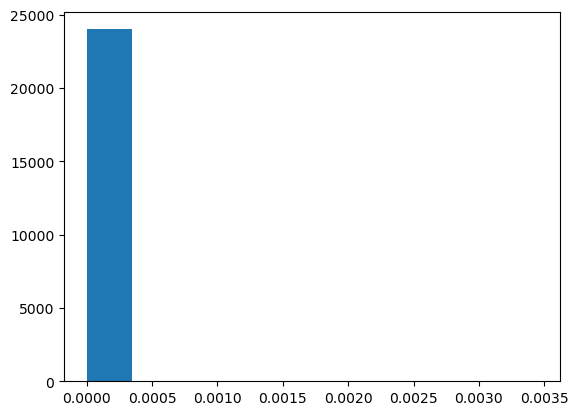

1.0


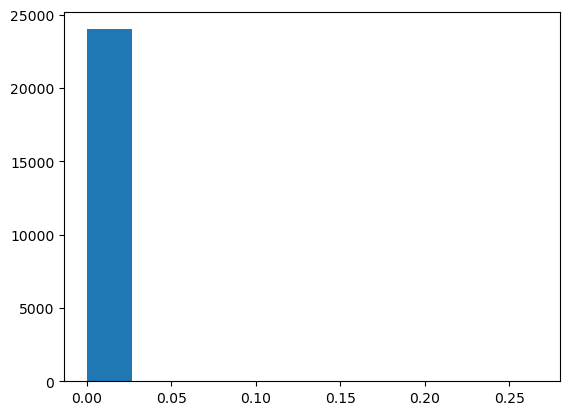

0.999875


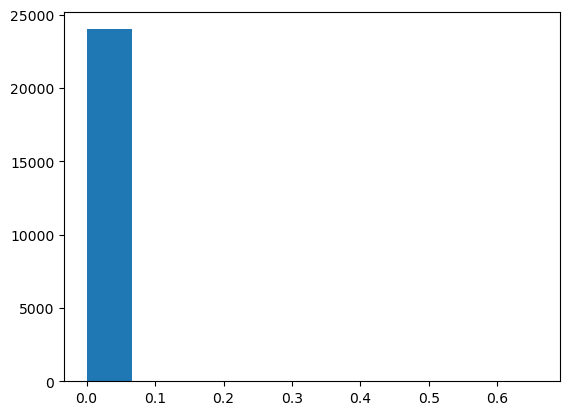

0.9999583333333333


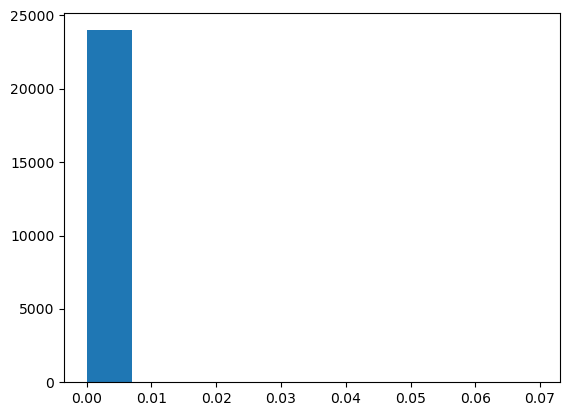

0.9999583333333333


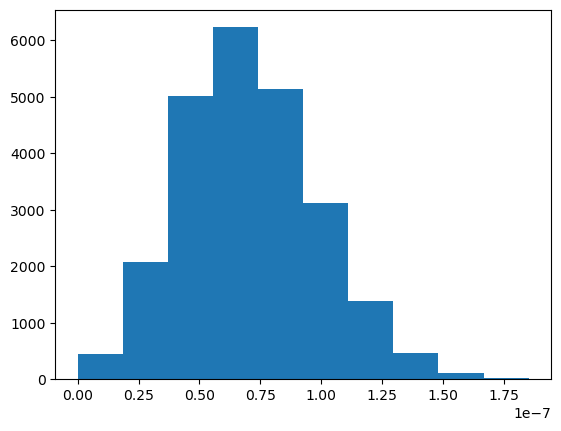

1.0


In [70]:
p_values_df = pd.DataFrame(p_values_all, index=mzs_list[0])
p_values_df.columns = p_values_df.columns.map(lambda x: np.array(samples_groups).flatten()[x]).map(lambda x: f"{get_brain_id(x)}_{get_treatment(x)}_{get_day(x)}")

for column in p_values_df.columns:
  plt.hist(p_values_df[column])
  plt.show()
  print((p_values_df[column] <= 0.05).sum() / p_values_df.shape[0])

In [ ]:

for category in df["Category"].unique():
  for sub_category in df["Subcategory"].unique():
    df_sub = df[(df["Category"] == category) & (df["Subcategory"] == sub_category)]
    t_stat_ind, p_value_ind = ttest_ind(df_sub[df_sub['Day'] == "0"]['Value'], df_sub[df_sub['Day'] == "5"]['Value'])

In [14]:

  
  
  map_idx = idx if idx % 2 == 0 else idx - 1
  new_cluster_labels = np.zeros(cluster_labels.shape)
  for label in np.unique(cluster_labels):
    if label > 0:
      new_cluster_labels[cluster_labels == label] = area_to_label[cluster_map[map_idx][label]]
  new_cluster_labels_list.append(new_cluster_labels)
  new_plot_clusters(new_cluster_labels, 4)

16

In [ ]:
# Lipids correlative to tumour but not to gray matter and white matter
# and how their values change

In [ ]:
paper_mzs = [
  611.50, 736.64, 682.58, 718.53, 768.53, 647.45, 740.50, 716.51, 605.45, 731.51, 
  757.53, 657.52, 773.52, 887.56, 659.50, 631.46,
  # 810.52, 798.64, 700.51, 754.56, 726.53, 868.53, 899.70, 824.66, 803.54, 834.64, 878.60, 844.64, 834.53, 860.62, 
  #800.49, 834.53
]

In [ ]:
# Apply correlation analysis on day 0 and 5 to the cluster lipid
# Apply zscore tp the correlation to find significant correlation
# see which one changed from day 0 to day 5